In [2]:
import torch
import numpy as np
from IPython.core.debugger import set_trace
import imageio
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.autograd import Variable
import torch.nn.functional as F


import importlib.util


from tkmodel.TwoCUM import TwoCUMfittingConc
from tkmodel.TwoCUM import TwoCUM

In [13]:
'''
Questions for 03/11/2021
Is my data generation okay, im worried what kind of random distribution i should use.
Should i normalise Fp to between 0 and 1 like the others?
Possibly add uncertainty to replicate the test data set a bit more?
'''

'\nQuestions for 03/11/2021\nIs my data generation okay, im worried what kind of random distribution i should use.\nShould i normalise Fp to between 0 and 1 like the others?\n'

In [52]:
#useful functions

def plot_PK(output, true):
    AIF_plot = np.load("MRI_other/TK_Modelling/AIF.npy")
    t_plot = np.arange(0,366,2.45)
    fitted_curve = TwoCUM(output, t_plot, AIF_plot, 0)
    plt.plot(t_plot, fitted_curve, label = 'Prediction')
    fitted_curve = TwoCUM(true, t_plot, AIF_plot, 0)
    plt.plot(t_plot, fitted_curve, label = 'True')
    plt.legend()
    plt.show()
    
def generate_xy(num_curves):
    AIF = np.load("MRI_other/TK_Modelling/AIF.npy")
    data_size = AIF.shape[0]
    t = np.arange(0,366,2.45)

    E = np.random.rand(1,num_curves) #0 to 1 for both E and vp
    vp = np.random.rand(1,num_curves)
    Fp = 1e-5*np.random.rand(1,num_curves)
    
#     Fp = abs(np.random.normal(size=num_curves, loc= 1e-5, scale = 1e-4)[None,:])

    E_Fp = np.concatenate((E, Fp), axis =0)
    y = np.concatenate((E_Fp, vp), axis =0)


    x = np.zeros((num_curves, data_size))
    for i in range(num_curves):
        x[i] = TwoCUM(y[:,i], t, AIF, 0)

    y = y.T 
    
    return x,y

def training_loop(x, y, epochs, plot = True):
    #x is the inputs, y is the true value of the predictions
    optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
    loss_func = torch.nn.MSELoss()

    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    inputs = Variable(x)
    outputs = Variable(y)
    torch_dataset = Data.TensorDataset(x, y) #wrapper to join x and y into one dataloader

    dataloader = Data.DataLoader(torch_dataset, batch_size=50, shuffle=True) #dataloader for batching and shuffle every epoch

    enum = epochs
    loss_list = []
    for epoch in range(enum):
        
        for i, (mini_x, mini_y) in enumerate(dataloader): # take out a batch for each step
            
            
            
            mini_x = Variable(mini_x)
            mini_y = Variable(mini_y)

            prediction = net(mini_x)     # input x and predict based on x
            #adjust prediction so that it simply needs to choose between 0 and 1
            prediction[:,1] = 1e-5*prediction[:,1]
            loss = loss_func(prediction, mini_y)
            
                
            optimizer.zero_grad()   # clear gradients so it doesn't stack up over the loops
            loss.backward()         # backprop
            optimizer.step() 
            
        loss_list.append(loss.detach().numpy())
        print(epoch, loss)
        if epoch%10 == 0 and plot == True:
            #plot one example of prediction vs true values
            print('Prediction, True Values')
            print(prediction[0].detach().numpy() , mini_y[0].detach().numpy())
            plot_PK(prediction[0].detach().numpy(), mini_y[0].detach().numpy())
    
    #plot the loss over epochs
    plt.plot(list(range(enum)), loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [57]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(150, 200)   # hidden layer
        self.hidden2 = torch.nn.Linear(200, 200)   # hidden layer
        self.predict = torch.nn.Linear(200, 3)

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x
    
#example custom loss function
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,y_pred, y_true):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
print(Net())

Net(
  (hidden): Linear(in_features=150, out_features=200, bias=True)
  (hidden2): Linear(in_features=200, out_features=200, bias=True)
  (predict): Linear(in_features=200, out_features=3, bias=True)
)


In [54]:
#maybe functions
def loss_fn(outputs, targets):
    #E, Fp, vp
    
    
    #For outputs
    #First calculate the parameter Tp
    
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t/Tp)
    R=exptTp*(1-E) + E
    #Calculate the convolution
    AIF1 = AIF.view(1, 1, -1)
    R = torch.flip(R, (0,)).view(1, 1, -1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(-1)
    F_out = Fp*temp[0:len(t)]
    
    #For targets - copy pasted
    E, Fp ,vp = targets[0], targets[1], targets[2]
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t/Tp)
    R=exptTp*(1-E) + E
    #Calculate the convolution
    AIF1 = AIF.view(1, 1, -1)
    R = torch.flip(R, (0,)).view(1, 1, -1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(-1)
    F_targets = Fp*temp[0:len(t)]
    
    return torch.sum((F_out - F_targets)**2)/F_out.shape[0]

(11999,)
0 tensor(0.2600, grad_fn=<MseLossBackward>)
Prediction, True Values
[-4.1288044e-02  4.5210399e-07 -8.1359416e-02] [4.4100037e-01 7.6048150e-06 2.8725705e-01]


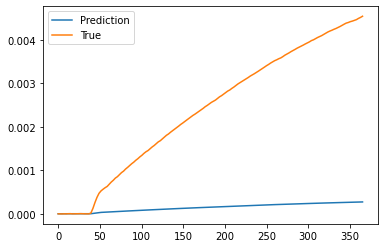

1 tensor(0.2950, grad_fn=<MseLossBackward>)
2 tensor(0.2863, grad_fn=<MseLossBackward>)
3 tensor(0.1996, grad_fn=<MseLossBackward>)
4 tensor(0.2370, grad_fn=<MseLossBackward>)
5 tensor(0.2204, grad_fn=<MseLossBackward>)
6 tensor(0.2156, grad_fn=<MseLossBackward>)
7 tensor(0.2110, grad_fn=<MseLossBackward>)
8 tensor(0.2163, grad_fn=<MseLossBackward>)
9 tensor(0.2685, grad_fn=<MseLossBackward>)
10 tensor(0.2093, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.1543266e-02 4.7499253e-07 1.4239350e-02] [4.9931210e-01 1.9815002e-06 3.8612431e-01]


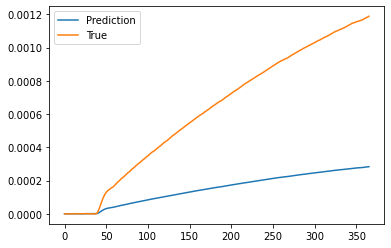

11 tensor(0.1825, grad_fn=<MseLossBackward>)
12 tensor(0.1856, grad_fn=<MseLossBackward>)
13 tensor(0.1713, grad_fn=<MseLossBackward>)
14 tensor(0.1840, grad_fn=<MseLossBackward>)
15 tensor(0.1798, grad_fn=<MseLossBackward>)
16 tensor(0.1817, grad_fn=<MseLossBackward>)
17 tensor(0.1637, grad_fn=<MseLossBackward>)
18 tensor(0.1832, grad_fn=<MseLossBackward>)
19 tensor(0.1437, grad_fn=<MseLossBackward>)
20 tensor(0.1427, grad_fn=<MseLossBackward>)
Prediction, True Values
[1.2909389e-01 4.9762656e-07 9.3931824e-02] [2.4216077e-01 4.3530163e-06 9.6496803e-01]


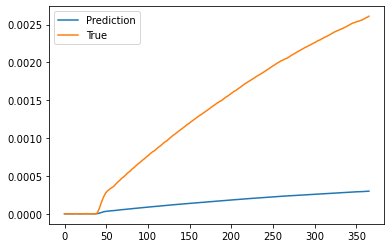

21 tensor(0.1455, grad_fn=<MseLossBackward>)
22 tensor(0.1508, grad_fn=<MseLossBackward>)
23 tensor(0.1536, grad_fn=<MseLossBackward>)
24 tensor(0.1353, grad_fn=<MseLossBackward>)
25 tensor(0.1392, grad_fn=<MseLossBackward>)
26 tensor(0.1252, grad_fn=<MseLossBackward>)
27 tensor(0.1237, grad_fn=<MseLossBackward>)
28 tensor(0.1211, grad_fn=<MseLossBackward>)
29 tensor(0.1291, grad_fn=<MseLossBackward>)
30 tensor(0.1097, grad_fn=<MseLossBackward>)
Prediction, True Values
[1.9402735e-01 5.2326328e-07 1.6036284e-01] [5.0429440e-01 2.9408616e-06 5.9011644e-01]


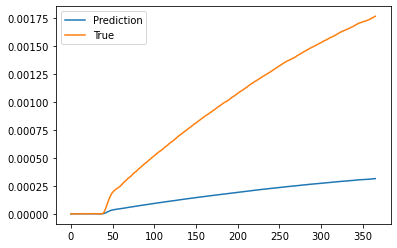

31 tensor(0.1110, grad_fn=<MseLossBackward>)
32 tensor(0.1329, grad_fn=<MseLossBackward>)
33 tensor(0.1323, grad_fn=<MseLossBackward>)
34 tensor(0.1097, grad_fn=<MseLossBackward>)
35 tensor(0.1212, grad_fn=<MseLossBackward>)
36 tensor(0.1085, grad_fn=<MseLossBackward>)
37 tensor(0.1072, grad_fn=<MseLossBackward>)
38 tensor(0.1205, grad_fn=<MseLossBackward>)
39 tensor(0.1435, grad_fn=<MseLossBackward>)
40 tensor(0.1290, grad_fn=<MseLossBackward>)
Prediction, True Values
[2.485952e-01 5.458935e-07 2.162091e-01] [5.628148e-01 4.434833e-06 1.834650e-01]


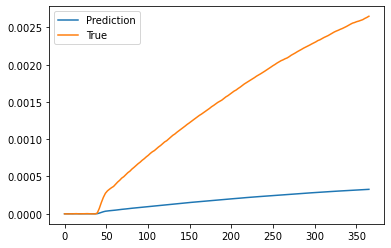

41 tensor(0.0914, grad_fn=<MseLossBackward>)
42 tensor(0.0910, grad_fn=<MseLossBackward>)
43 tensor(0.0973, grad_fn=<MseLossBackward>)
44 tensor(0.0918, grad_fn=<MseLossBackward>)
45 tensor(0.0929, grad_fn=<MseLossBackward>)
46 tensor(0.0857, grad_fn=<MseLossBackward>)
47 tensor(0.1188, grad_fn=<MseLossBackward>)
48 tensor(0.0881, grad_fn=<MseLossBackward>)
49 tensor(0.0814, grad_fn=<MseLossBackward>)
50 tensor(0.0995, grad_fn=<MseLossBackward>)
Prediction, True Values
[2.9462364e-01 5.6557809e-07 2.6325279e-01] [6.2200660e-01 1.1581951e-06 2.0692265e-01]


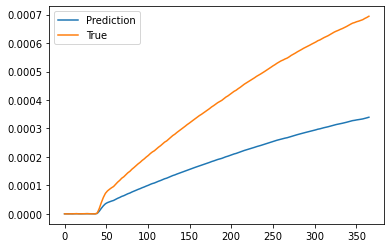

51 tensor(0.0764, grad_fn=<MseLossBackward>)
52 tensor(0.0869, grad_fn=<MseLossBackward>)
53 tensor(0.0701, grad_fn=<MseLossBackward>)
54 tensor(0.0826, grad_fn=<MseLossBackward>)
55 tensor(0.0942, grad_fn=<MseLossBackward>)
56 tensor(0.0838, grad_fn=<MseLossBackward>)
57 tensor(0.0816, grad_fn=<MseLossBackward>)
58 tensor(0.0642, grad_fn=<MseLossBackward>)
59 tensor(0.0853, grad_fn=<MseLossBackward>)
60 tensor(0.0733, grad_fn=<MseLossBackward>)
Prediction, True Values
[3.3297187e-01 5.8091211e-07 3.0260667e-01] [6.3020128e-01 2.4823287e-06 5.9055328e-01]


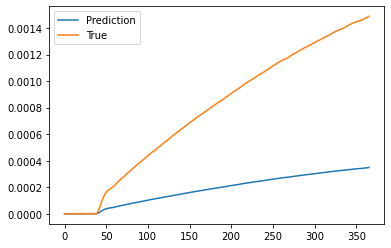

61 tensor(0.0763, grad_fn=<MseLossBackward>)
62 tensor(0.0709, grad_fn=<MseLossBackward>)
63 tensor(0.0970, grad_fn=<MseLossBackward>)
64 tensor(0.0800, grad_fn=<MseLossBackward>)
65 tensor(0.0878, grad_fn=<MseLossBackward>)
66 tensor(0.0796, grad_fn=<MseLossBackward>)
67 tensor(0.0778, grad_fn=<MseLossBackward>)
68 tensor(0.0726, grad_fn=<MseLossBackward>)
69 tensor(0.0659, grad_fn=<MseLossBackward>)
70 tensor(0.0726, grad_fn=<MseLossBackward>)
Prediction, True Values
[3.6486012e-01 5.9366880e-07 3.3563176e-01] [7.2066975e-01 2.9351040e-06 1.8737364e-01]


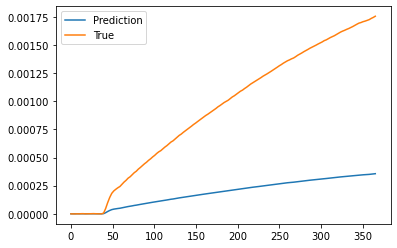

71 tensor(0.0809, grad_fn=<MseLossBackward>)
72 tensor(0.0779, grad_fn=<MseLossBackward>)
73 tensor(0.0597, grad_fn=<MseLossBackward>)
74 tensor(0.0720, grad_fn=<MseLossBackward>)
75 tensor(0.0683, grad_fn=<MseLossBackward>)
76 tensor(0.0850, grad_fn=<MseLossBackward>)
77 tensor(0.0724, grad_fn=<MseLossBackward>)
78 tensor(0.0682, grad_fn=<MseLossBackward>)
79 tensor(0.0580, grad_fn=<MseLossBackward>)
80 tensor(0.0673, grad_fn=<MseLossBackward>)
Prediction, True Values
[3.9149535e-01 6.0507926e-07 3.6311534e-01] [3.3004147e-01 1.3592743e-06 4.0358648e-01]


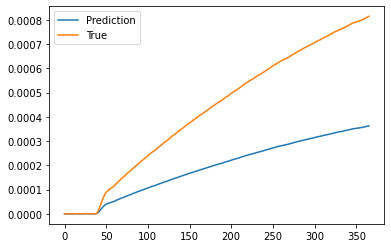

81 tensor(0.0713, grad_fn=<MseLossBackward>)
82 tensor(0.0593, grad_fn=<MseLossBackward>)
83 tensor(0.0550, grad_fn=<MseLossBackward>)
84 tensor(0.0624, grad_fn=<MseLossBackward>)
85 tensor(0.0639, grad_fn=<MseLossBackward>)
86 tensor(0.0705, grad_fn=<MseLossBackward>)
87 tensor(0.0597, grad_fn=<MseLossBackward>)
88 tensor(0.0636, grad_fn=<MseLossBackward>)
89 tensor(0.0637, grad_fn=<MseLossBackward>)
90 tensor(0.0542, grad_fn=<MseLossBackward>)
Prediction, True Values
[4.1353476e-01 6.1320378e-07 3.8571835e-01] [8.6251247e-01 7.7124223e-06 2.2556843e-01]


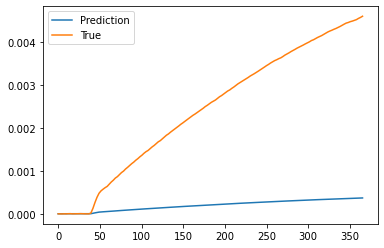

91 tensor(0.0625, grad_fn=<MseLossBackward>)
92 tensor(0.0580, grad_fn=<MseLossBackward>)
93 tensor(0.0707, grad_fn=<MseLossBackward>)
94 tensor(0.0612, grad_fn=<MseLossBackward>)
95 tensor(0.0591, grad_fn=<MseLossBackward>)
96 tensor(0.0655, grad_fn=<MseLossBackward>)
97 tensor(0.0674, grad_fn=<MseLossBackward>)
98 tensor(0.0700, grad_fn=<MseLossBackward>)
99 tensor(0.0632, grad_fn=<MseLossBackward>)
100 tensor(0.0589, grad_fn=<MseLossBackward>)
Prediction, True Values
[4.3157005e-01 6.2112309e-07 4.0448183e-01] [3.7317818e-01 4.2000042e-06 9.4459534e-01]


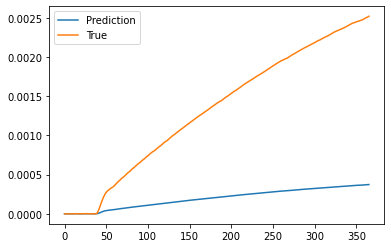

101 tensor(0.0597, grad_fn=<MseLossBackward>)
102 tensor(0.0685, grad_fn=<MseLossBackward>)
103 tensor(0.0634, grad_fn=<MseLossBackward>)
104 tensor(0.0674, grad_fn=<MseLossBackward>)
105 tensor(0.0607, grad_fn=<MseLossBackward>)
106 tensor(0.0616, grad_fn=<MseLossBackward>)
107 tensor(0.0517, grad_fn=<MseLossBackward>)
108 tensor(0.0598, grad_fn=<MseLossBackward>)
109 tensor(0.0578, grad_fn=<MseLossBackward>)
110 tensor(0.0596, grad_fn=<MseLossBackward>)
Prediction, True Values
[4.4645676e-01 6.2691294e-07 4.1973308e-01] [9.5893151e-01 8.3015120e-06 4.0750512e-01]


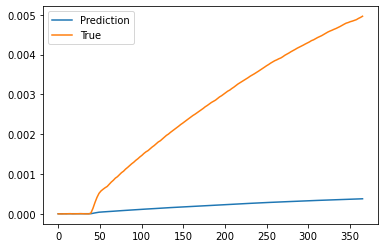

111 tensor(0.0532, grad_fn=<MseLossBackward>)
112 tensor(0.0563, grad_fn=<MseLossBackward>)
113 tensor(0.0664, grad_fn=<MseLossBackward>)
114 tensor(0.0634, grad_fn=<MseLossBackward>)
115 tensor(0.0631, grad_fn=<MseLossBackward>)
116 tensor(0.0626, grad_fn=<MseLossBackward>)
117 tensor(0.0644, grad_fn=<MseLossBackward>)
118 tensor(0.0529, grad_fn=<MseLossBackward>)
119 tensor(0.0612, grad_fn=<MseLossBackward>)
120 tensor(0.0502, grad_fn=<MseLossBackward>)
Prediction, True Values
[4.5862710e-01 6.3226105e-07 4.3228793e-01] [7.1433949e-01 8.1042836e-06 4.7598287e-01]


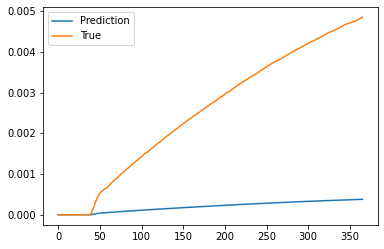

121 tensor(0.0539, grad_fn=<MseLossBackward>)
122 tensor(0.0555, grad_fn=<MseLossBackward>)
123 tensor(0.0643, grad_fn=<MseLossBackward>)
124 tensor(0.0701, grad_fn=<MseLossBackward>)
125 tensor(0.0517, grad_fn=<MseLossBackward>)
126 tensor(0.0568, grad_fn=<MseLossBackward>)
127 tensor(0.0543, grad_fn=<MseLossBackward>)
128 tensor(0.0625, grad_fn=<MseLossBackward>)
129 tensor(0.0600, grad_fn=<MseLossBackward>)
130 tensor(0.0567, grad_fn=<MseLossBackward>)
Prediction, True Values
[4.6828806e-01 6.3748269e-07 4.4252858e-01] [1.4684796e-01 2.5021404e-06 9.3047923e-01]


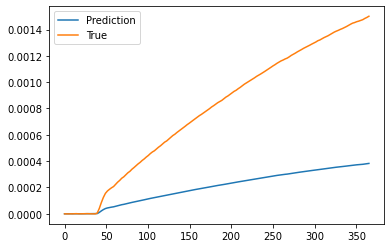

131 tensor(0.0527, grad_fn=<MseLossBackward>)
132 tensor(0.0564, grad_fn=<MseLossBackward>)
133 tensor(0.0661, grad_fn=<MseLossBackward>)
134 tensor(0.0572, grad_fn=<MseLossBackward>)
135 tensor(0.0539, grad_fn=<MseLossBackward>)
136 tensor(0.0509, grad_fn=<MseLossBackward>)
137 tensor(0.0661, grad_fn=<MseLossBackward>)
138 tensor(0.0584, grad_fn=<MseLossBackward>)
139 tensor(0.0632, grad_fn=<MseLossBackward>)
140 tensor(0.0645, grad_fn=<MseLossBackward>)
Prediction, True Values
[4.7638637e-01 6.4007298e-07 4.5085800e-01] [6.959299e-01 9.068558e-06 6.303457e-02]


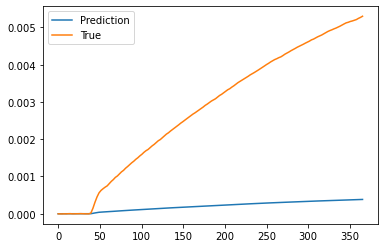

141 tensor(0.0637, grad_fn=<MseLossBackward>)
142 tensor(0.0647, grad_fn=<MseLossBackward>)
143 tensor(0.0571, grad_fn=<MseLossBackward>)
144 tensor(0.0561, grad_fn=<MseLossBackward>)
145 tensor(0.0570, grad_fn=<MseLossBackward>)
146 tensor(0.0574, grad_fn=<MseLossBackward>)
147 tensor(0.0495, grad_fn=<MseLossBackward>)
148 tensor(0.0506, grad_fn=<MseLossBackward>)
149 tensor(0.0621, grad_fn=<MseLossBackward>)
150 tensor(0.0534, grad_fn=<MseLossBackward>)
Prediction, True Values
[4.8279783e-01 6.4322484e-07 4.5754409e-01] [7.1600747e-01 7.5196899e-06 2.0862204e-01]


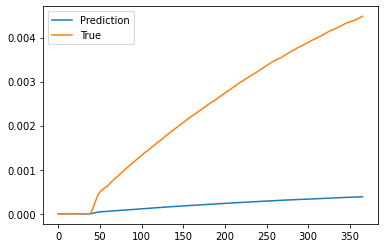

151 tensor(0.0635, grad_fn=<MseLossBackward>)
152 tensor(0.0648, grad_fn=<MseLossBackward>)
153 tensor(0.0685, grad_fn=<MseLossBackward>)
154 tensor(0.0574, grad_fn=<MseLossBackward>)
155 tensor(0.0532, grad_fn=<MseLossBackward>)
156 tensor(0.0745, grad_fn=<MseLossBackward>)
157 tensor(0.0543, grad_fn=<MseLossBackward>)
158 tensor(0.0637, grad_fn=<MseLossBackward>)
159 tensor(0.0527, grad_fn=<MseLossBackward>)
160 tensor(0.0621, grad_fn=<MseLossBackward>)
Prediction, True Values
[4.8799190e-01 6.4597873e-07 4.6314389e-01] [8.3889556e-01 5.0380600e-06 9.8541506e-02]


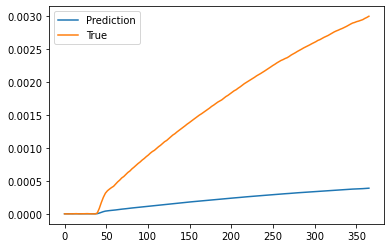

161 tensor(0.0569, grad_fn=<MseLossBackward>)
162 tensor(0.0549, grad_fn=<MseLossBackward>)
163 tensor(0.0587, grad_fn=<MseLossBackward>)
164 tensor(0.0585, grad_fn=<MseLossBackward>)
165 tensor(0.0484, grad_fn=<MseLossBackward>)
166 tensor(0.0596, grad_fn=<MseLossBackward>)
167 tensor(0.0549, grad_fn=<MseLossBackward>)
168 tensor(0.0542, grad_fn=<MseLossBackward>)
169 tensor(0.0542, grad_fn=<MseLossBackward>)
170 tensor(0.0571, grad_fn=<MseLossBackward>)
Prediction, True Values
[4.9207416e-01 6.4835382e-07 4.6760359e-01] [5.7679003e-01 1.7946394e-06 3.8292429e-01]


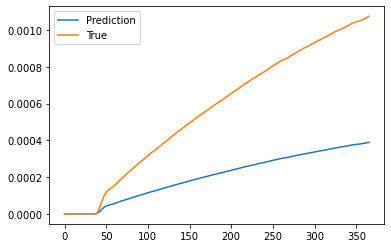

171 tensor(0.0591, grad_fn=<MseLossBackward>)
172 tensor(0.0609, grad_fn=<MseLossBackward>)
173 tensor(0.0608, grad_fn=<MseLossBackward>)
174 tensor(0.0552, grad_fn=<MseLossBackward>)
175 tensor(0.0643, grad_fn=<MseLossBackward>)
176 tensor(0.0518, grad_fn=<MseLossBackward>)
177 tensor(0.0591, grad_fn=<MseLossBackward>)
178 tensor(0.0550, grad_fn=<MseLossBackward>)
179 tensor(0.0629, grad_fn=<MseLossBackward>)
180 tensor(0.0536, grad_fn=<MseLossBackward>)
Prediction, True Values
[4.9561602e-01 6.4895283e-07 4.7116256e-01] [3.8992396e-01 8.2580682e-06 2.9451242e-02]


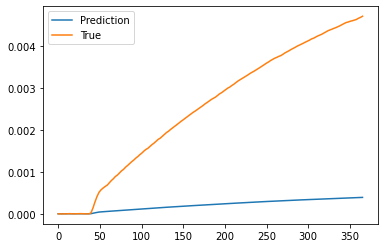

181 tensor(0.0578, grad_fn=<MseLossBackward>)
182 tensor(0.0588, grad_fn=<MseLossBackward>)
183 tensor(0.0628, grad_fn=<MseLossBackward>)
184 tensor(0.0553, grad_fn=<MseLossBackward>)
185 tensor(0.0530, grad_fn=<MseLossBackward>)
186 tensor(0.0589, grad_fn=<MseLossBackward>)
187 tensor(0.0607, grad_fn=<MseLossBackward>)
188 tensor(0.0569, grad_fn=<MseLossBackward>)
189 tensor(0.0500, grad_fn=<MseLossBackward>)
190 tensor(0.0590, grad_fn=<MseLossBackward>)
Prediction, True Values
[4.9835896e-01 6.5037040e-07 4.7398484e-01] [7.6896304e-01 7.0170022e-06 6.7097336e-02]


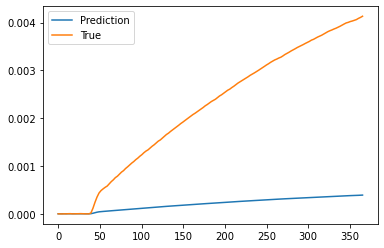

191 tensor(0.0615, grad_fn=<MseLossBackward>)
192 tensor(0.0609, grad_fn=<MseLossBackward>)
193 tensor(0.0576, grad_fn=<MseLossBackward>)
194 tensor(0.0653, grad_fn=<MseLossBackward>)
195 tensor(0.0522, grad_fn=<MseLossBackward>)
196 tensor(0.0610, grad_fn=<MseLossBackward>)
197 tensor(0.0660, grad_fn=<MseLossBackward>)
198 tensor(0.0494, grad_fn=<MseLossBackward>)
199 tensor(0.0598, grad_fn=<MseLossBackward>)
200 tensor(0.0483, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0046325e-01 6.5205586e-07 4.7638059e-01] [4.4375712e-01 2.3772122e-06 1.8309093e-01]


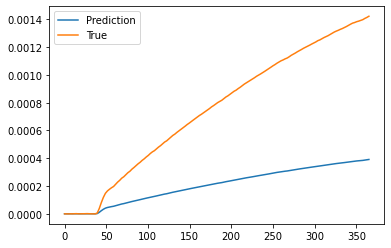

201 tensor(0.0521, grad_fn=<MseLossBackward>)
202 tensor(0.0601, grad_fn=<MseLossBackward>)
203 tensor(0.0624, grad_fn=<MseLossBackward>)
204 tensor(0.0626, grad_fn=<MseLossBackward>)
205 tensor(0.0580, grad_fn=<MseLossBackward>)
206 tensor(0.0491, grad_fn=<MseLossBackward>)
207 tensor(0.0601, grad_fn=<MseLossBackward>)
208 tensor(0.0642, grad_fn=<MseLossBackward>)
209 tensor(0.0553, grad_fn=<MseLossBackward>)
210 tensor(0.0555, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0226361e-01 6.5254983e-07 4.7822124e-01] [4.6886425e-02 4.5718439e-06 1.2712525e-01]


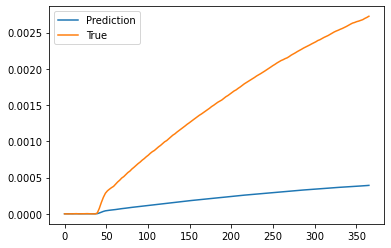

211 tensor(0.0534, grad_fn=<MseLossBackward>)
212 tensor(0.0504, grad_fn=<MseLossBackward>)
213 tensor(0.0508, grad_fn=<MseLossBackward>)
214 tensor(0.0653, grad_fn=<MseLossBackward>)
215 tensor(0.0507, grad_fn=<MseLossBackward>)
216 tensor(0.0582, grad_fn=<MseLossBackward>)
217 tensor(0.0583, grad_fn=<MseLossBackward>)
218 tensor(0.0640, grad_fn=<MseLossBackward>)
219 tensor(0.0604, grad_fn=<MseLossBackward>)
220 tensor(0.0595, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0363040e-01 6.5332426e-07 4.7972423e-01] [1.8333124e-01 3.7724731e-06 7.9742748e-01]


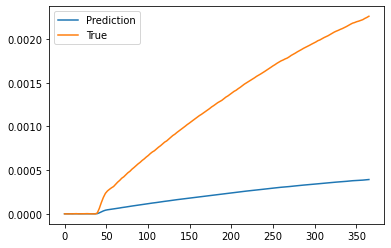

221 tensor(0.0579, grad_fn=<MseLossBackward>)
222 tensor(0.0638, grad_fn=<MseLossBackward>)
223 tensor(0.0542, grad_fn=<MseLossBackward>)
224 tensor(0.0614, grad_fn=<MseLossBackward>)
225 tensor(0.0541, grad_fn=<MseLossBackward>)
226 tensor(0.0516, grad_fn=<MseLossBackward>)
227 tensor(0.0475, grad_fn=<MseLossBackward>)
228 tensor(0.0583, grad_fn=<MseLossBackward>)
229 tensor(0.0546, grad_fn=<MseLossBackward>)
230 tensor(0.0544, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0464779e-01 6.5429117e-07 4.8100710e-01] [6.2200660e-01 1.1581951e-06 2.0692265e-01]


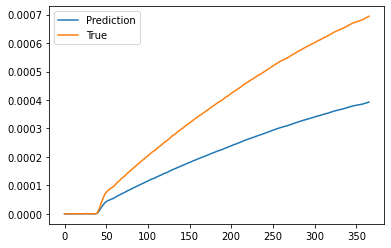

231 tensor(0.0563, grad_fn=<MseLossBackward>)
232 tensor(0.0563, grad_fn=<MseLossBackward>)
233 tensor(0.0629, grad_fn=<MseLossBackward>)
234 tensor(0.0576, grad_fn=<MseLossBackward>)
235 tensor(0.0657, grad_fn=<MseLossBackward>)
236 tensor(0.0501, grad_fn=<MseLossBackward>)
237 tensor(0.0511, grad_fn=<MseLossBackward>)
238 tensor(0.0594, grad_fn=<MseLossBackward>)
239 tensor(0.0550, grad_fn=<MseLossBackward>)
240 tensor(0.0575, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0559366e-01 6.5426320e-07 4.8196727e-01] [1.8333124e-01 3.7724731e-06 7.9742748e-01]


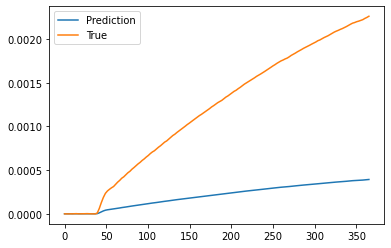

241 tensor(0.0614, grad_fn=<MseLossBackward>)
242 tensor(0.0532, grad_fn=<MseLossBackward>)
243 tensor(0.0529, grad_fn=<MseLossBackward>)
244 tensor(0.0670, grad_fn=<MseLossBackward>)
245 tensor(0.0533, grad_fn=<MseLossBackward>)
246 tensor(0.0564, grad_fn=<MseLossBackward>)
247 tensor(0.0623, grad_fn=<MseLossBackward>)
248 tensor(0.0568, grad_fn=<MseLossBackward>)
249 tensor(0.0544, grad_fn=<MseLossBackward>)
250 tensor(0.0508, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0643885e-01 6.5446415e-07 4.8271000e-01] [5.7201242e-01 4.7847725e-06 8.4412283e-01]


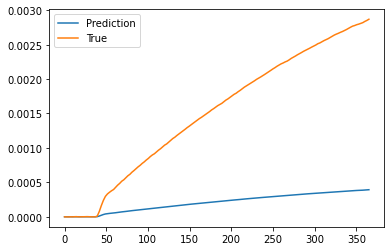

251 tensor(0.0605, grad_fn=<MseLossBackward>)
252 tensor(0.0603, grad_fn=<MseLossBackward>)
253 tensor(0.0548, grad_fn=<MseLossBackward>)
254 tensor(0.0647, grad_fn=<MseLossBackward>)
255 tensor(0.0578, grad_fn=<MseLossBackward>)
256 tensor(0.0531, grad_fn=<MseLossBackward>)
257 tensor(0.0588, grad_fn=<MseLossBackward>)
258 tensor(0.0496, grad_fn=<MseLossBackward>)
259 tensor(0.0559, grad_fn=<MseLossBackward>)
260 tensor(0.0568, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0700092e-01 6.5412183e-07 4.8335668e-01] [8.401121e-01 8.535243e-06 4.305440e-01]


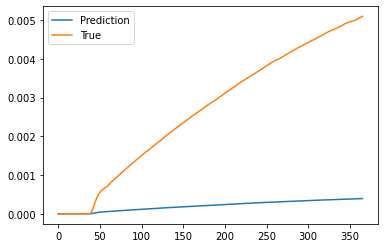

261 tensor(0.0534, grad_fn=<MseLossBackward>)
262 tensor(0.0655, grad_fn=<MseLossBackward>)
263 tensor(0.0593, grad_fn=<MseLossBackward>)
264 tensor(0.0611, grad_fn=<MseLossBackward>)
265 tensor(0.0506, grad_fn=<MseLossBackward>)
266 tensor(0.0621, grad_fn=<MseLossBackward>)
267 tensor(0.0599, grad_fn=<MseLossBackward>)
268 tensor(0.0609, grad_fn=<MseLossBackward>)
269 tensor(0.0570, grad_fn=<MseLossBackward>)
270 tensor(0.0625, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.074773e-01 6.543860e-07 4.838501e-01] [4.6792564e-01 8.2503429e-06 8.5755497e-01]


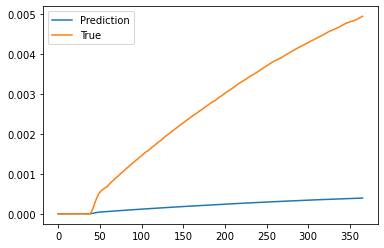

271 tensor(0.0570, grad_fn=<MseLossBackward>)
272 tensor(0.0646, grad_fn=<MseLossBackward>)
273 tensor(0.0535, grad_fn=<MseLossBackward>)
274 tensor(0.0582, grad_fn=<MseLossBackward>)
275 tensor(0.0560, grad_fn=<MseLossBackward>)
276 tensor(0.0532, grad_fn=<MseLossBackward>)
277 tensor(0.0606, grad_fn=<MseLossBackward>)
278 tensor(0.0560, grad_fn=<MseLossBackward>)
279 tensor(0.0470, grad_fn=<MseLossBackward>)
280 tensor(0.0575, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0779194e-01 6.5541093e-07 4.8433468e-01] [7.9839486e-01 2.7453466e-06 4.3212077e-01]


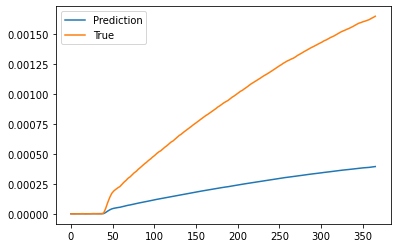

281 tensor(0.0656, grad_fn=<MseLossBackward>)
282 tensor(0.0693, grad_fn=<MseLossBackward>)
283 tensor(0.0615, grad_fn=<MseLossBackward>)
284 tensor(0.0567, grad_fn=<MseLossBackward>)
285 tensor(0.0560, grad_fn=<MseLossBackward>)
286 tensor(0.0533, grad_fn=<MseLossBackward>)
287 tensor(0.0516, grad_fn=<MseLossBackward>)
288 tensor(0.0666, grad_fn=<MseLossBackward>)
289 tensor(0.0535, grad_fn=<MseLossBackward>)
290 tensor(0.0564, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0813168e-01 6.5452832e-07 4.8460472e-01] [3.5982102e-01 9.0770327e-06 9.3581021e-01]


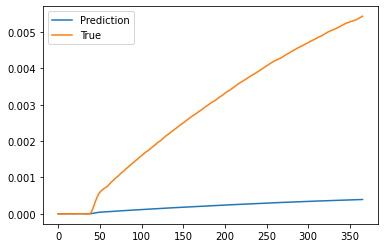

291 tensor(0.0567, grad_fn=<MseLossBackward>)
292 tensor(0.0526, grad_fn=<MseLossBackward>)
293 tensor(0.0582, grad_fn=<MseLossBackward>)
294 tensor(0.0594, grad_fn=<MseLossBackward>)
295 tensor(0.0631, grad_fn=<MseLossBackward>)
296 tensor(0.0578, grad_fn=<MseLossBackward>)
297 tensor(0.0668, grad_fn=<MseLossBackward>)
298 tensor(0.0457, grad_fn=<MseLossBackward>)
299 tensor(0.0606, grad_fn=<MseLossBackward>)
300 tensor(0.0598, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0836825e-01 6.5501717e-07 4.8478398e-01] [4.7863322e-01 6.8317036e-06 5.4228199e-01]


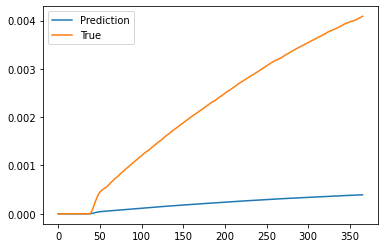

301 tensor(0.0577, grad_fn=<MseLossBackward>)
302 tensor(0.0602, grad_fn=<MseLossBackward>)
303 tensor(0.0639, grad_fn=<MseLossBackward>)
304 tensor(0.0535, grad_fn=<MseLossBackward>)
305 tensor(0.0557, grad_fn=<MseLossBackward>)
306 tensor(0.0608, grad_fn=<MseLossBackward>)
307 tensor(0.0519, grad_fn=<MseLossBackward>)
308 tensor(0.0596, grad_fn=<MseLossBackward>)
309 tensor(0.0602, grad_fn=<MseLossBackward>)
310 tensor(0.0495, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0852555e-01 6.5553195e-07 4.8501092e-01] [4.4272304e-01 3.9479519e-06 3.0598170e-01]


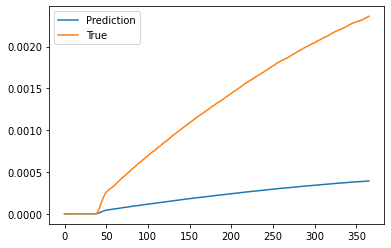

311 tensor(0.0578, grad_fn=<MseLossBackward>)
312 tensor(0.0592, grad_fn=<MseLossBackward>)
313 tensor(0.0552, grad_fn=<MseLossBackward>)
314 tensor(0.0532, grad_fn=<MseLossBackward>)
315 tensor(0.0617, grad_fn=<MseLossBackward>)
316 tensor(0.0602, grad_fn=<MseLossBackward>)
317 tensor(0.0560, grad_fn=<MseLossBackward>)
318 tensor(0.0556, grad_fn=<MseLossBackward>)
319 tensor(0.0582, grad_fn=<MseLossBackward>)
320 tensor(0.0660, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0880313e-01 6.5469385e-07 4.8527205e-01] [3.9222036e-02 9.7509992e-06 9.3413597e-01]


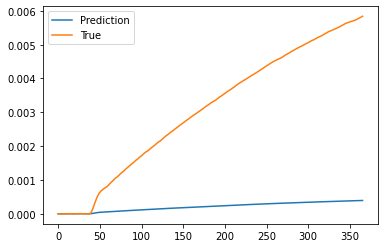

321 tensor(0.0576, grad_fn=<MseLossBackward>)
322 tensor(0.0646, grad_fn=<MseLossBackward>)
323 tensor(0.0625, grad_fn=<MseLossBackward>)
324 tensor(0.0573, grad_fn=<MseLossBackward>)
325 tensor(0.0519, grad_fn=<MseLossBackward>)
326 tensor(0.0530, grad_fn=<MseLossBackward>)
327 tensor(0.0583, grad_fn=<MseLossBackward>)
328 tensor(0.0529, grad_fn=<MseLossBackward>)
329 tensor(0.0539, grad_fn=<MseLossBackward>)
330 tensor(0.0511, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0881112e-01 6.5513757e-07 4.8539501e-01] [5.3655297e-01 7.6620345e-06 4.2712312e-02]


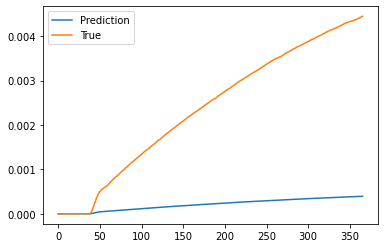

331 tensor(0.0564, grad_fn=<MseLossBackward>)
332 tensor(0.0548, grad_fn=<MseLossBackward>)
333 tensor(0.0639, grad_fn=<MseLossBackward>)
334 tensor(0.0654, grad_fn=<MseLossBackward>)
335 tensor(0.0606, grad_fn=<MseLossBackward>)
336 tensor(0.0566, grad_fn=<MseLossBackward>)
337 tensor(0.0586, grad_fn=<MseLossBackward>)
338 tensor(0.0498, grad_fn=<MseLossBackward>)
339 tensor(0.0581, grad_fn=<MseLossBackward>)
340 tensor(0.0626, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0888354e-01 6.5558993e-07 4.8542714e-01] [4.2236874e-01 4.7420399e-06 7.9343885e-01]


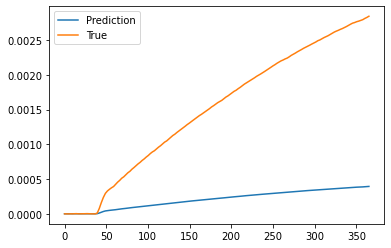

341 tensor(0.0525, grad_fn=<MseLossBackward>)
342 tensor(0.0496, grad_fn=<MseLossBackward>)
343 tensor(0.0559, grad_fn=<MseLossBackward>)
344 tensor(0.0601, grad_fn=<MseLossBackward>)
345 tensor(0.0522, grad_fn=<MseLossBackward>)
346 tensor(0.0576, grad_fn=<MseLossBackward>)
347 tensor(0.0623, grad_fn=<MseLossBackward>)
348 tensor(0.0586, grad_fn=<MseLossBackward>)
349 tensor(0.0505, grad_fn=<MseLossBackward>)
350 tensor(0.0647, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0881267e-01 6.5639080e-07 4.8576191e-01] [1.5662242e-01 4.9467917e-07 1.4740647e-01]


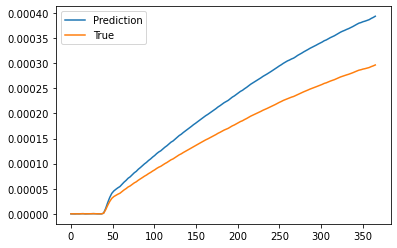

351 tensor(0.0604, grad_fn=<MseLossBackward>)
352 tensor(0.0544, grad_fn=<MseLossBackward>)
353 tensor(0.0603, grad_fn=<MseLossBackward>)
354 tensor(0.0562, grad_fn=<MseLossBackward>)
355 tensor(0.0493, grad_fn=<MseLossBackward>)
356 tensor(0.0611, grad_fn=<MseLossBackward>)
357 tensor(0.0569, grad_fn=<MseLossBackward>)
358 tensor(0.0539, grad_fn=<MseLossBackward>)
359 tensor(0.0542, grad_fn=<MseLossBackward>)
360 tensor(0.0606, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0902945e-01 6.5606901e-07 4.8561990e-01] [9.6496379e-01 2.0664888e-06 2.4400879e-01]


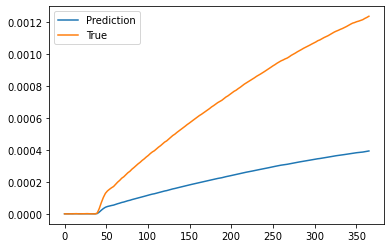

361 tensor(0.0513, grad_fn=<MseLossBackward>)
362 tensor(0.0586, grad_fn=<MseLossBackward>)
363 tensor(0.0543, grad_fn=<MseLossBackward>)
364 tensor(0.0592, grad_fn=<MseLossBackward>)
365 tensor(0.0542, grad_fn=<MseLossBackward>)
366 tensor(0.0627, grad_fn=<MseLossBackward>)
367 tensor(0.0577, grad_fn=<MseLossBackward>)
368 tensor(0.0557, grad_fn=<MseLossBackward>)
369 tensor(0.0564, grad_fn=<MseLossBackward>)
370 tensor(0.0563, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0916439e-01 6.5550302e-07 4.8575568e-01] [7.3386294e-01 6.2484964e-06 3.0834073e-01]


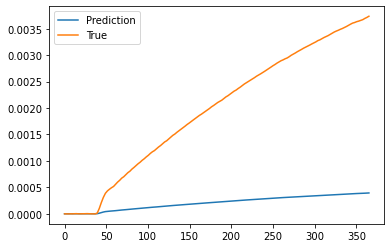

371 tensor(0.0605, grad_fn=<MseLossBackward>)
372 tensor(0.0561, grad_fn=<MseLossBackward>)
373 tensor(0.0593, grad_fn=<MseLossBackward>)
374 tensor(0.0530, grad_fn=<MseLossBackward>)
375 tensor(0.0596, grad_fn=<MseLossBackward>)
376 tensor(0.0602, grad_fn=<MseLossBackward>)
377 tensor(0.0522, grad_fn=<MseLossBackward>)
378 tensor(0.0577, grad_fn=<MseLossBackward>)
379 tensor(0.0570, grad_fn=<MseLossBackward>)
380 tensor(0.0580, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0897443e-01 6.5623982e-07 4.8576093e-01] [8.4884536e-01 1.1388752e-06 5.3451306e-01]


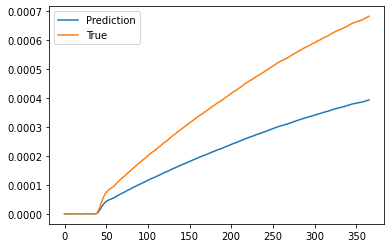

381 tensor(0.0524, grad_fn=<MseLossBackward>)
382 tensor(0.0581, grad_fn=<MseLossBackward>)
383 tensor(0.0542, grad_fn=<MseLossBackward>)
384 tensor(0.0606, grad_fn=<MseLossBackward>)
385 tensor(0.0550, grad_fn=<MseLossBackward>)
386 tensor(0.0583, grad_fn=<MseLossBackward>)
387 tensor(0.0521, grad_fn=<MseLossBackward>)
388 tensor(0.0558, grad_fn=<MseLossBackward>)
389 tensor(0.0588, grad_fn=<MseLossBackward>)
390 tensor(0.0611, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0924569e-01 6.5537637e-07 4.8589152e-01] [7.1601564e-01 7.4358918e-06 9.5419191e-02]


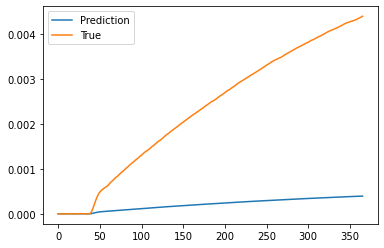

391 tensor(0.0561, grad_fn=<MseLossBackward>)
392 tensor(0.0643, grad_fn=<MseLossBackward>)
393 tensor(0.0495, grad_fn=<MseLossBackward>)
394 tensor(0.0567, grad_fn=<MseLossBackward>)
395 tensor(0.0623, grad_fn=<MseLossBackward>)
396 tensor(0.0664, grad_fn=<MseLossBackward>)
397 tensor(0.0673, grad_fn=<MseLossBackward>)
398 tensor(0.0496, grad_fn=<MseLossBackward>)
399 tensor(0.0557, grad_fn=<MseLossBackward>)
400 tensor(0.0597, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.091780e-01 6.555891e-07 4.857961e-01] [6.1489719e-01 5.7488201e-06 3.8853413e-01]


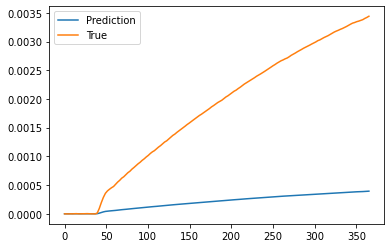

401 tensor(0.0592, grad_fn=<MseLossBackward>)
402 tensor(0.0519, grad_fn=<MseLossBackward>)
403 tensor(0.0577, grad_fn=<MseLossBackward>)
404 tensor(0.0464, grad_fn=<MseLossBackward>)
405 tensor(0.0603, grad_fn=<MseLossBackward>)
406 tensor(0.0606, grad_fn=<MseLossBackward>)
407 tensor(0.0467, grad_fn=<MseLossBackward>)
408 tensor(0.0638, grad_fn=<MseLossBackward>)
409 tensor(0.0477, grad_fn=<MseLossBackward>)
410 tensor(0.0552, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0930130e-01 6.5512836e-07 4.8592150e-01] [7.905648e-01 8.829917e-06 8.116037e-01]


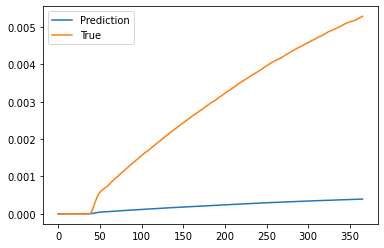

411 tensor(0.0602, grad_fn=<MseLossBackward>)
412 tensor(0.0528, grad_fn=<MseLossBackward>)
413 tensor(0.0688, grad_fn=<MseLossBackward>)
414 tensor(0.0488, grad_fn=<MseLossBackward>)
415 tensor(0.0670, grad_fn=<MseLossBackward>)
416 tensor(0.0478, grad_fn=<MseLossBackward>)
417 tensor(0.0610, grad_fn=<MseLossBackward>)
418 tensor(0.0585, grad_fn=<MseLossBackward>)
419 tensor(0.0591, grad_fn=<MseLossBackward>)
420 tensor(0.0534, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0913453e-01 6.5558572e-07 4.8589402e-01] [7.4771303e-01 5.8390533e-06 6.0444695e-01]


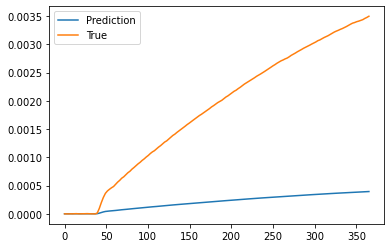

421 tensor(0.0622, grad_fn=<MseLossBackward>)
422 tensor(0.0603, grad_fn=<MseLossBackward>)
423 tensor(0.0568, grad_fn=<MseLossBackward>)
424 tensor(0.0603, grad_fn=<MseLossBackward>)
425 tensor(0.0607, grad_fn=<MseLossBackward>)
426 tensor(0.0566, grad_fn=<MseLossBackward>)
427 tensor(0.0587, grad_fn=<MseLossBackward>)
428 tensor(0.0605, grad_fn=<MseLossBackward>)
429 tensor(0.0566, grad_fn=<MseLossBackward>)
430 tensor(0.0584, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0928462e-01 6.5614972e-07 4.8592752e-01] [9.9804044e-01 2.3483810e-06 7.3560357e-02]


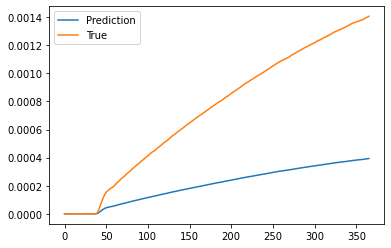

431 tensor(0.0609, grad_fn=<MseLossBackward>)
432 tensor(0.0664, grad_fn=<MseLossBackward>)
433 tensor(0.0581, grad_fn=<MseLossBackward>)
434 tensor(0.0518, grad_fn=<MseLossBackward>)
435 tensor(0.0488, grad_fn=<MseLossBackward>)
436 tensor(0.0558, grad_fn=<MseLossBackward>)
437 tensor(0.0689, grad_fn=<MseLossBackward>)
438 tensor(0.0513, grad_fn=<MseLossBackward>)
439 tensor(0.0553, grad_fn=<MseLossBackward>)
440 tensor(0.0638, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0930285e-01 6.5573198e-07 4.8592684e-01] [6.1441499e-01 5.1670086e-06 6.8404740e-01]


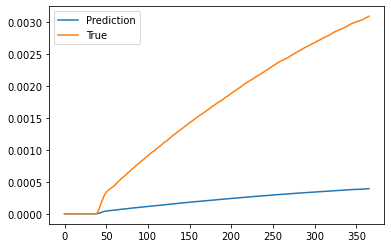

441 tensor(0.0630, grad_fn=<MseLossBackward>)
442 tensor(0.0552, grad_fn=<MseLossBackward>)
443 tensor(0.0487, grad_fn=<MseLossBackward>)
444 tensor(0.0612, grad_fn=<MseLossBackward>)
445 tensor(0.0577, grad_fn=<MseLossBackward>)
446 tensor(0.0530, grad_fn=<MseLossBackward>)
447 tensor(0.0592, grad_fn=<MseLossBackward>)
448 tensor(0.0544, grad_fn=<MseLossBackward>)
449 tensor(0.0595, grad_fn=<MseLossBackward>)
450 tensor(0.0597, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0917768e-01 6.5619332e-07 4.8594448e-01] [7.3281860e-01 1.9218746e-06 3.1988990e-01]


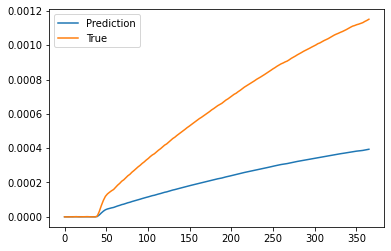

451 tensor(0.0610, grad_fn=<MseLossBackward>)
452 tensor(0.0584, grad_fn=<MseLossBackward>)
453 tensor(0.0514, grad_fn=<MseLossBackward>)
454 tensor(0.0581, grad_fn=<MseLossBackward>)
455 tensor(0.0539, grad_fn=<MseLossBackward>)
456 tensor(0.0626, grad_fn=<MseLossBackward>)
457 tensor(0.0557, grad_fn=<MseLossBackward>)
458 tensor(0.0471, grad_fn=<MseLossBackward>)
459 tensor(0.0633, grad_fn=<MseLossBackward>)
460 tensor(0.0512, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0925517e-01 6.5613625e-07 4.8587757e-01] [2.1470055e-01 2.3158022e-06 6.3121754e-01]


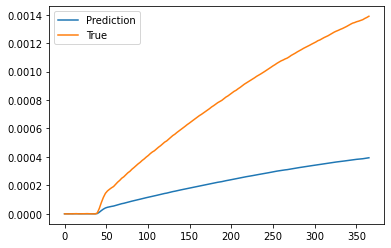

461 tensor(0.0584, grad_fn=<MseLossBackward>)
462 tensor(0.0688, grad_fn=<MseLossBackward>)
463 tensor(0.0558, grad_fn=<MseLossBackward>)
464 tensor(0.0539, grad_fn=<MseLossBackward>)
465 tensor(0.0540, grad_fn=<MseLossBackward>)
466 tensor(0.0508, grad_fn=<MseLossBackward>)
467 tensor(0.0493, grad_fn=<MseLossBackward>)
468 tensor(0.0566, grad_fn=<MseLossBackward>)
469 tensor(0.0634, grad_fn=<MseLossBackward>)
470 tensor(0.0671, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0933594e-01 6.5545885e-07 4.8597342e-01] [3.2396460e-01 7.1000632e-06 9.6266663e-01]


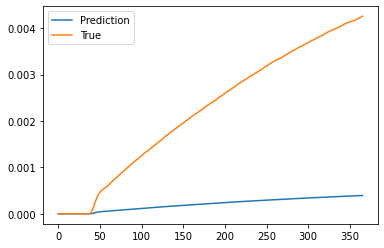

471 tensor(0.0629, grad_fn=<MseLossBackward>)
472 tensor(0.0680, grad_fn=<MseLossBackward>)
473 tensor(0.0513, grad_fn=<MseLossBackward>)
474 tensor(0.0601, grad_fn=<MseLossBackward>)
475 tensor(0.0487, grad_fn=<MseLossBackward>)
476 tensor(0.0511, grad_fn=<MseLossBackward>)
477 tensor(0.0602, grad_fn=<MseLossBackward>)
478 tensor(0.0533, grad_fn=<MseLossBackward>)
479 tensor(0.0526, grad_fn=<MseLossBackward>)
480 tensor(0.0639, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0937426e-01 6.5598948e-07 4.8603198e-01] [2.7383232e-01 3.6973522e-06 9.7574854e-01]


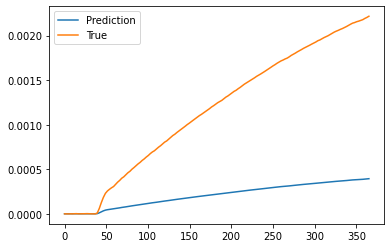

481 tensor(0.0551, grad_fn=<MseLossBackward>)
482 tensor(0.0560, grad_fn=<MseLossBackward>)
483 tensor(0.0567, grad_fn=<MseLossBackward>)
484 tensor(0.0637, grad_fn=<MseLossBackward>)
485 tensor(0.0615, grad_fn=<MseLossBackward>)
486 tensor(0.0674, grad_fn=<MseLossBackward>)
487 tensor(0.0547, grad_fn=<MseLossBackward>)
488 tensor(0.0515, grad_fn=<MseLossBackward>)
489 tensor(0.0531, grad_fn=<MseLossBackward>)
490 tensor(0.0492, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0922525e-01 6.5615029e-07 4.8595208e-01] [3.0400965e-01 2.2922079e-06 5.3259468e-01]


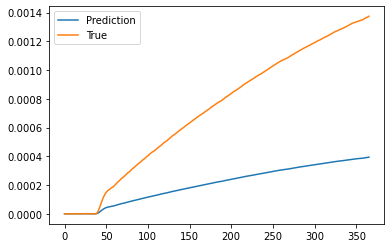

491 tensor(0.0560, grad_fn=<MseLossBackward>)
492 tensor(0.0581, grad_fn=<MseLossBackward>)
493 tensor(0.0550, grad_fn=<MseLossBackward>)
494 tensor(0.0631, grad_fn=<MseLossBackward>)
495 tensor(0.0595, grad_fn=<MseLossBackward>)
496 tensor(0.0570, grad_fn=<MseLossBackward>)
497 tensor(0.0650, grad_fn=<MseLossBackward>)
498 tensor(0.0501, grad_fn=<MseLossBackward>)
499 tensor(0.0578, grad_fn=<MseLossBackward>)
500 tensor(0.0542, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0930405e-01 6.5542861e-07 4.8593375e-01] [4.7015741e-01 7.1973686e-06 8.2768005e-01]


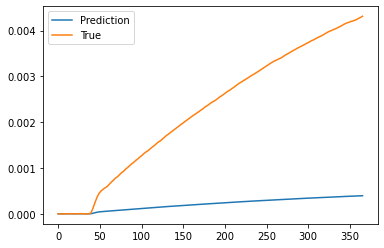

501 tensor(0.0506, grad_fn=<MseLossBackward>)
502 tensor(0.0608, grad_fn=<MseLossBackward>)
503 tensor(0.0576, grad_fn=<MseLossBackward>)
504 tensor(0.0582, grad_fn=<MseLossBackward>)
505 tensor(0.0583, grad_fn=<MseLossBackward>)
506 tensor(0.0525, grad_fn=<MseLossBackward>)
507 tensor(0.0594, grad_fn=<MseLossBackward>)
508 tensor(0.0577, grad_fn=<MseLossBackward>)
509 tensor(0.0639, grad_fn=<MseLossBackward>)
510 tensor(0.0615, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0927317e-01 6.5554644e-07 4.8593840e-01] [1.2453794e-01 6.3716138e-06 8.4183764e-01]


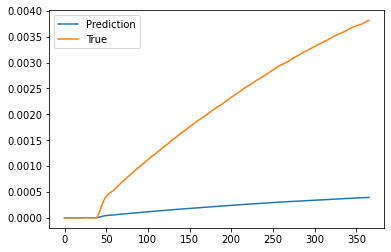

511 tensor(0.0544, grad_fn=<MseLossBackward>)
512 tensor(0.0545, grad_fn=<MseLossBackward>)
513 tensor(0.0574, grad_fn=<MseLossBackward>)
514 tensor(0.0573, grad_fn=<MseLossBackward>)
515 tensor(0.0611, grad_fn=<MseLossBackward>)
516 tensor(0.0574, grad_fn=<MseLossBackward>)
517 tensor(0.0543, grad_fn=<MseLossBackward>)
518 tensor(0.0590, grad_fn=<MseLossBackward>)
519 tensor(0.0598, grad_fn=<MseLossBackward>)
520 tensor(0.0565, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0908625e-01 6.5661908e-07 4.8602808e-01] [1.178703e-01 6.972440e-08 1.658343e-01]


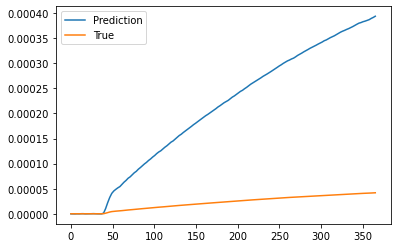

521 tensor(0.0607, grad_fn=<MseLossBackward>)
522 tensor(0.0568, grad_fn=<MseLossBackward>)
523 tensor(0.0514, grad_fn=<MseLossBackward>)
524 tensor(0.0536, grad_fn=<MseLossBackward>)
525 tensor(0.0506, grad_fn=<MseLossBackward>)
526 tensor(0.0574, grad_fn=<MseLossBackward>)
527 tensor(0.0660, grad_fn=<MseLossBackward>)
528 tensor(0.0587, grad_fn=<MseLossBackward>)
529 tensor(0.0632, grad_fn=<MseLossBackward>)
530 tensor(0.0551, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0922799e-01 6.5616769e-07 4.8602504e-01] [4.153290e-01 2.293034e-06 8.163153e-01]


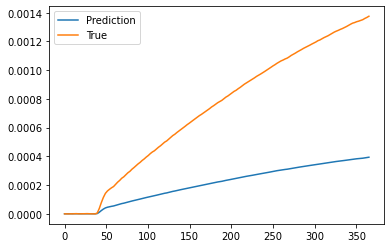

531 tensor(0.0566, grad_fn=<MseLossBackward>)
532 tensor(0.0579, grad_fn=<MseLossBackward>)
533 tensor(0.0586, grad_fn=<MseLossBackward>)
534 tensor(0.0663, grad_fn=<MseLossBackward>)
535 tensor(0.0576, grad_fn=<MseLossBackward>)
536 tensor(0.0608, grad_fn=<MseLossBackward>)
537 tensor(0.0606, grad_fn=<MseLossBackward>)
538 tensor(0.0598, grad_fn=<MseLossBackward>)
539 tensor(0.0594, grad_fn=<MseLossBackward>)
540 tensor(0.0517, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0917572e-01 6.5663363e-07 4.8601544e-01] [4.2971838e-02 7.7810931e-08 3.2228714e-01]


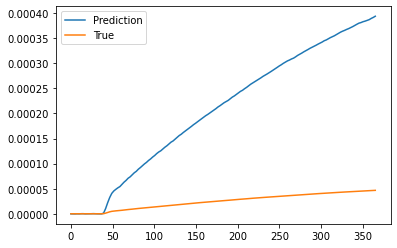

541 tensor(0.0648, grad_fn=<MseLossBackward>)
542 tensor(0.0540, grad_fn=<MseLossBackward>)
543 tensor(0.0599, grad_fn=<MseLossBackward>)
544 tensor(0.0539, grad_fn=<MseLossBackward>)
545 tensor(0.0529, grad_fn=<MseLossBackward>)
546 tensor(0.0463, grad_fn=<MseLossBackward>)
547 tensor(0.0599, grad_fn=<MseLossBackward>)
548 tensor(0.0594, grad_fn=<MseLossBackward>)
549 tensor(0.0542, grad_fn=<MseLossBackward>)
550 tensor(0.0608, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0923473e-01 6.5586283e-07 4.8594886e-01] [2.5928479e-01 4.2178376e-06 1.8638210e-01]


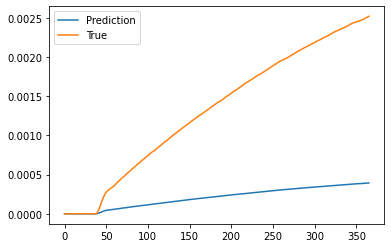

551 tensor(0.0572, grad_fn=<MseLossBackward>)
552 tensor(0.0594, grad_fn=<MseLossBackward>)
553 tensor(0.0557, grad_fn=<MseLossBackward>)
554 tensor(0.0625, grad_fn=<MseLossBackward>)
555 tensor(0.0617, grad_fn=<MseLossBackward>)
556 tensor(0.0497, grad_fn=<MseLossBackward>)
557 tensor(0.0567, grad_fn=<MseLossBackward>)
558 tensor(0.0680, grad_fn=<MseLossBackward>)
559 tensor(0.0558, grad_fn=<MseLossBackward>)
560 tensor(0.0579, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0942177e-01 6.5514087e-07 4.8593736e-01] [1.33828834e-01 8.97089831e-06 1.21515535e-01]


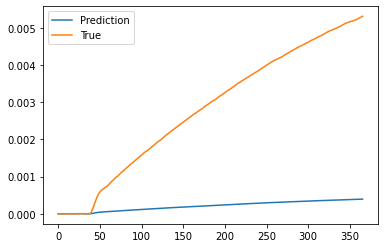

561 tensor(0.0585, grad_fn=<MseLossBackward>)
562 tensor(0.0613, grad_fn=<MseLossBackward>)
563 tensor(0.0550, grad_fn=<MseLossBackward>)
564 tensor(0.0606, grad_fn=<MseLossBackward>)
565 tensor(0.0548, grad_fn=<MseLossBackward>)
566 tensor(0.0575, grad_fn=<MseLossBackward>)
567 tensor(0.0655, grad_fn=<MseLossBackward>)
568 tensor(0.0617, grad_fn=<MseLossBackward>)
569 tensor(0.0598, grad_fn=<MseLossBackward>)
570 tensor(0.0485, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0919062e-01 6.5600483e-07 4.8590291e-01] [9.3281254e-02 3.1282777e-06 1.5096237e-01]


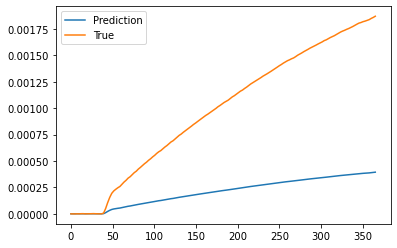

571 tensor(0.0564, grad_fn=<MseLossBackward>)
572 tensor(0.0536, grad_fn=<MseLossBackward>)
573 tensor(0.0503, grad_fn=<MseLossBackward>)
574 tensor(0.0508, grad_fn=<MseLossBackward>)
575 tensor(0.0584, grad_fn=<MseLossBackward>)
576 tensor(0.0592, grad_fn=<MseLossBackward>)
577 tensor(0.0633, grad_fn=<MseLossBackward>)
578 tensor(0.0621, grad_fn=<MseLossBackward>)
579 tensor(0.0538, grad_fn=<MseLossBackward>)
580 tensor(0.0552, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.093740e-01 6.555837e-07 4.860220e-01] [3.2816616e-01 6.3977232e-06 7.3002797e-01]


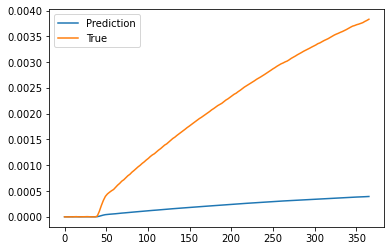

581 tensor(0.0546, grad_fn=<MseLossBackward>)
582 tensor(0.0595, grad_fn=<MseLossBackward>)
583 tensor(0.0556, grad_fn=<MseLossBackward>)
584 tensor(0.0611, grad_fn=<MseLossBackward>)
585 tensor(0.0546, grad_fn=<MseLossBackward>)
586 tensor(0.0577, grad_fn=<MseLossBackward>)
587 tensor(0.0560, grad_fn=<MseLossBackward>)
588 tensor(0.0561, grad_fn=<MseLossBackward>)
589 tensor(0.0586, grad_fn=<MseLossBackward>)
590 tensor(0.0562, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0930381e-01 6.5559146e-07 4.8590067e-01] [7.0700169e-01 6.0617435e-06 5.6385219e-01]


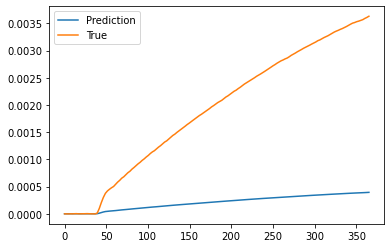

591 tensor(0.0562, grad_fn=<MseLossBackward>)
592 tensor(0.0528, grad_fn=<MseLossBackward>)
593 tensor(0.0636, grad_fn=<MseLossBackward>)
594 tensor(0.0585, grad_fn=<MseLossBackward>)
595 tensor(0.0732, grad_fn=<MseLossBackward>)
596 tensor(0.0662, grad_fn=<MseLossBackward>)
597 tensor(0.0638, grad_fn=<MseLossBackward>)
598 tensor(0.0640, grad_fn=<MseLossBackward>)
599 tensor(0.0610, grad_fn=<MseLossBackward>)
600 tensor(0.0552, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0927186e-01 6.5557498e-07 4.8590848e-01] [1.5191765e-01 6.1355613e-06 2.9178610e-01]


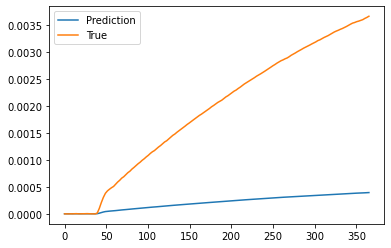

601 tensor(0.0590, grad_fn=<MseLossBackward>)
602 tensor(0.0592, grad_fn=<MseLossBackward>)
603 tensor(0.0581, grad_fn=<MseLossBackward>)
604 tensor(0.0568, grad_fn=<MseLossBackward>)
605 tensor(0.0565, grad_fn=<MseLossBackward>)
606 tensor(0.0632, grad_fn=<MseLossBackward>)
607 tensor(0.0562, grad_fn=<MseLossBackward>)
608 tensor(0.0568, grad_fn=<MseLossBackward>)
609 tensor(0.0526, grad_fn=<MseLossBackward>)
610 tensor(0.0525, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0934893e-01 6.5512955e-07 4.8597577e-01] [2.1807915e-01 8.9370751e-06 5.3620893e-01]


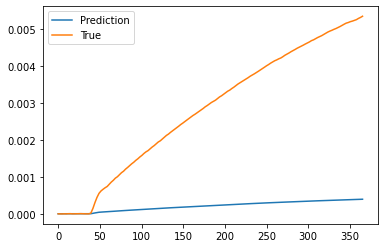

611 tensor(0.0546, grad_fn=<MseLossBackward>)
612 tensor(0.0627, grad_fn=<MseLossBackward>)
613 tensor(0.0575, grad_fn=<MseLossBackward>)
614 tensor(0.0518, grad_fn=<MseLossBackward>)
615 tensor(0.0574, grad_fn=<MseLossBackward>)
616 tensor(0.0615, grad_fn=<MseLossBackward>)
617 tensor(0.0676, grad_fn=<MseLossBackward>)
618 tensor(0.0556, grad_fn=<MseLossBackward>)
619 tensor(0.0570, grad_fn=<MseLossBackward>)
620 tensor(0.0660, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.092875e-01 6.553415e-07 4.860414e-01] [9.6247476e-01 7.7890454e-06 7.6831710e-01]


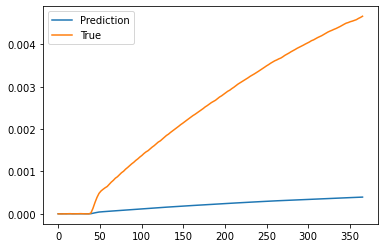

621 tensor(0.0552, grad_fn=<MseLossBackward>)
622 tensor(0.0492, grad_fn=<MseLossBackward>)
623 tensor(0.0552, grad_fn=<MseLossBackward>)
624 tensor(0.0526, grad_fn=<MseLossBackward>)
625 tensor(0.0663, grad_fn=<MseLossBackward>)
626 tensor(0.0588, grad_fn=<MseLossBackward>)
627 tensor(0.0556, grad_fn=<MseLossBackward>)
628 tensor(0.0630, grad_fn=<MseLossBackward>)
629 tensor(0.0562, grad_fn=<MseLossBackward>)
630 tensor(0.0626, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0929040e-01 6.5527894e-07 4.8606277e-01] [9.9359190e-01 8.1665221e-06 7.4398035e-01]


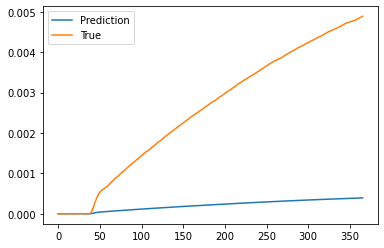

631 tensor(0.0532, grad_fn=<MseLossBackward>)
632 tensor(0.0619, grad_fn=<MseLossBackward>)
633 tensor(0.0574, grad_fn=<MseLossBackward>)
634 tensor(0.0588, grad_fn=<MseLossBackward>)
635 tensor(0.0557, grad_fn=<MseLossBackward>)
636 tensor(0.0554, grad_fn=<MseLossBackward>)
637 tensor(0.0532, grad_fn=<MseLossBackward>)
638 tensor(0.0575, grad_fn=<MseLossBackward>)
639 tensor(0.0535, grad_fn=<MseLossBackward>)
640 tensor(0.0568, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0933731e-01 6.5558885e-07 4.8591918e-01] [2.6639256e-01 6.1548121e-06 4.7433656e-01]


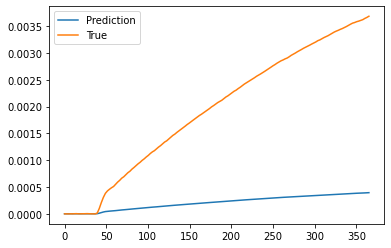

641 tensor(0.0546, grad_fn=<MseLossBackward>)
642 tensor(0.0522, grad_fn=<MseLossBackward>)
643 tensor(0.0505, grad_fn=<MseLossBackward>)
644 tensor(0.0556, grad_fn=<MseLossBackward>)
645 tensor(0.0464, grad_fn=<MseLossBackward>)
646 tensor(0.0647, grad_fn=<MseLossBackward>)
647 tensor(0.0563, grad_fn=<MseLossBackward>)
648 tensor(0.0604, grad_fn=<MseLossBackward>)
649 tensor(0.0594, grad_fn=<MseLossBackward>)
650 tensor(0.0532, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0936532e-01 6.5539786e-07 4.8601452e-01] [8.3063716e-01 7.6564993e-06 4.7118060e-02]


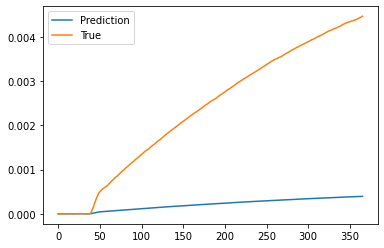

651 tensor(0.0510, grad_fn=<MseLossBackward>)
652 tensor(0.0557, grad_fn=<MseLossBackward>)
653 tensor(0.0614, grad_fn=<MseLossBackward>)
654 tensor(0.0600, grad_fn=<MseLossBackward>)
655 tensor(0.0569, grad_fn=<MseLossBackward>)
656 tensor(0.0652, grad_fn=<MseLossBackward>)
657 tensor(0.0599, grad_fn=<MseLossBackward>)
658 tensor(0.0515, grad_fn=<MseLossBackward>)
659 tensor(0.0625, grad_fn=<MseLossBackward>)
660 tensor(0.0537, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0941956e-01 6.5544708e-07 4.8587430e-01] [7.7820265e-01 7.1452805e-06 5.6029814e-01]


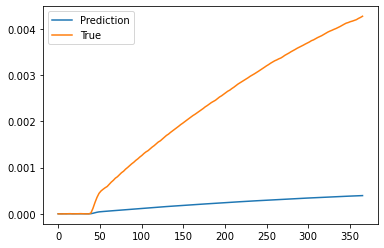

661 tensor(0.0470, grad_fn=<MseLossBackward>)
662 tensor(0.0551, grad_fn=<MseLossBackward>)
663 tensor(0.0518, grad_fn=<MseLossBackward>)
664 tensor(0.0606, grad_fn=<MseLossBackward>)
665 tensor(0.0599, grad_fn=<MseLossBackward>)
666 tensor(0.0503, grad_fn=<MseLossBackward>)
667 tensor(0.0607, grad_fn=<MseLossBackward>)
668 tensor(0.0637, grad_fn=<MseLossBackward>)
669 tensor(0.0526, grad_fn=<MseLossBackward>)
670 tensor(0.0524, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0928539e-01 6.5549978e-07 4.8594248e-01] [7.4910504e-01 6.7001492e-06 3.9871141e-01]


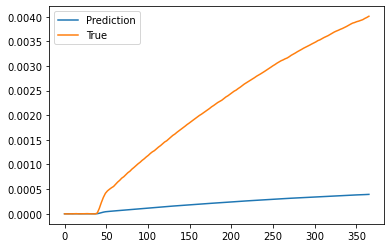

671 tensor(0.0665, grad_fn=<MseLossBackward>)
672 tensor(0.0562, grad_fn=<MseLossBackward>)
673 tensor(0.0557, grad_fn=<MseLossBackward>)
674 tensor(0.0575, grad_fn=<MseLossBackward>)
675 tensor(0.0496, grad_fn=<MseLossBackward>)
676 tensor(0.0537, grad_fn=<MseLossBackward>)
677 tensor(0.0589, grad_fn=<MseLossBackward>)
678 tensor(0.0579, grad_fn=<MseLossBackward>)
679 tensor(0.0599, grad_fn=<MseLossBackward>)
680 tensor(0.0464, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0930697e-01 6.5562841e-07 4.8596585e-01] [1.7334814e-01 5.9058666e-06 5.4542458e-01]


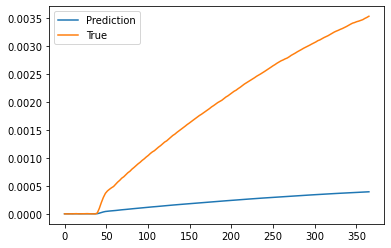

681 tensor(0.0493, grad_fn=<MseLossBackward>)
682 tensor(0.0561, grad_fn=<MseLossBackward>)
683 tensor(0.0571, grad_fn=<MseLossBackward>)
684 tensor(0.0524, grad_fn=<MseLossBackward>)
685 tensor(0.0705, grad_fn=<MseLossBackward>)
686 tensor(0.0577, grad_fn=<MseLossBackward>)
687 tensor(0.0650, grad_fn=<MseLossBackward>)
688 tensor(0.0615, grad_fn=<MseLossBackward>)
689 tensor(0.0679, grad_fn=<MseLossBackward>)
690 tensor(0.0628, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0940847e-01 6.5496994e-07 4.8598564e-01] [6.5174288e-01 9.8744267e-06 8.1959456e-01]


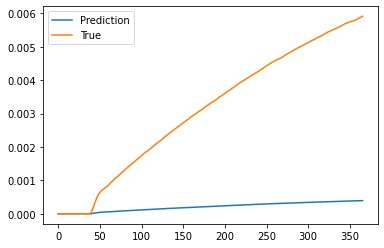

691 tensor(0.0527, grad_fn=<MseLossBackward>)
692 tensor(0.0501, grad_fn=<MseLossBackward>)
693 tensor(0.0589, grad_fn=<MseLossBackward>)
694 tensor(0.0561, grad_fn=<MseLossBackward>)
695 tensor(0.0560, grad_fn=<MseLossBackward>)
696 tensor(0.0615, grad_fn=<MseLossBackward>)
697 tensor(0.0585, grad_fn=<MseLossBackward>)
698 tensor(0.0582, grad_fn=<MseLossBackward>)
699 tensor(0.0564, grad_fn=<MseLossBackward>)
700 tensor(0.0551, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0921828e-01 6.5610857e-07 4.8599184e-01] [3.6714607e-01 2.6166445e-06 2.8941968e-01]


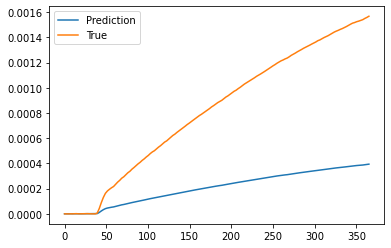

701 tensor(0.0572, grad_fn=<MseLossBackward>)
702 tensor(0.0643, grad_fn=<MseLossBackward>)
703 tensor(0.0560, grad_fn=<MseLossBackward>)
704 tensor(0.0561, grad_fn=<MseLossBackward>)
705 tensor(0.0607, grad_fn=<MseLossBackward>)
706 tensor(0.0567, grad_fn=<MseLossBackward>)
707 tensor(0.0610, grad_fn=<MseLossBackward>)
708 tensor(0.0637, grad_fn=<MseLossBackward>)
709 tensor(0.0549, grad_fn=<MseLossBackward>)
710 tensor(0.0576, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0931275e-01 6.5566417e-07 4.8602611e-01] [6.800958e-02 5.768523e-06 9.043208e-01]


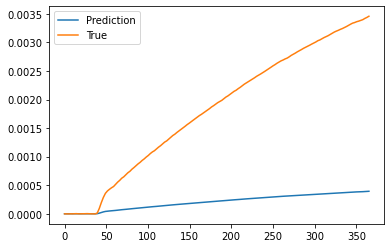

711 tensor(0.0586, grad_fn=<MseLossBackward>)
712 tensor(0.0577, grad_fn=<MseLossBackward>)
713 tensor(0.0619, grad_fn=<MseLossBackward>)
714 tensor(0.0581, grad_fn=<MseLossBackward>)
715 tensor(0.0556, grad_fn=<MseLossBackward>)
716 tensor(0.0562, grad_fn=<MseLossBackward>)
717 tensor(0.0598, grad_fn=<MseLossBackward>)
718 tensor(0.0611, grad_fn=<MseLossBackward>)
719 tensor(0.0586, grad_fn=<MseLossBackward>)
720 tensor(0.0631, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0919878e-01 6.5640018e-07 4.8590806e-01] [7.2566554e-02 7.9710725e-07 8.2512069e-01]


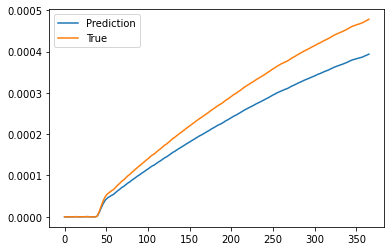

721 tensor(0.0519, grad_fn=<MseLossBackward>)
722 tensor(0.0504, grad_fn=<MseLossBackward>)
723 tensor(0.0549, grad_fn=<MseLossBackward>)
724 tensor(0.0517, grad_fn=<MseLossBackward>)
725 tensor(0.0604, grad_fn=<MseLossBackward>)
726 tensor(0.0561, grad_fn=<MseLossBackward>)
727 tensor(0.0603, grad_fn=<MseLossBackward>)
728 tensor(0.0537, grad_fn=<MseLossBackward>)
729 tensor(0.0575, grad_fn=<MseLossBackward>)
730 tensor(0.0635, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0928909e-01 6.5575551e-07 4.8596427e-01] [3.9477849e-01 5.0330559e-06 9.2223024e-01]


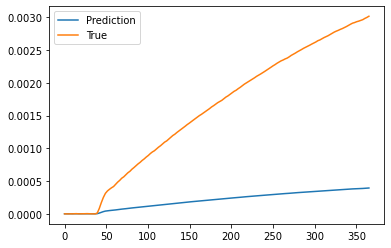

731 tensor(0.0581, grad_fn=<MseLossBackward>)
732 tensor(0.0628, grad_fn=<MseLossBackward>)
733 tensor(0.0523, grad_fn=<MseLossBackward>)
734 tensor(0.0540, grad_fn=<MseLossBackward>)
735 tensor(0.0486, grad_fn=<MseLossBackward>)
736 tensor(0.0533, grad_fn=<MseLossBackward>)
737 tensor(0.0591, grad_fn=<MseLossBackward>)
738 tensor(0.0667, grad_fn=<MseLossBackward>)
739 tensor(0.0592, grad_fn=<MseLossBackward>)
740 tensor(0.0518, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0930130e-01 6.5535812e-07 4.8589826e-01] [5.6543005e-01 7.5475186e-06 7.3719895e-01]


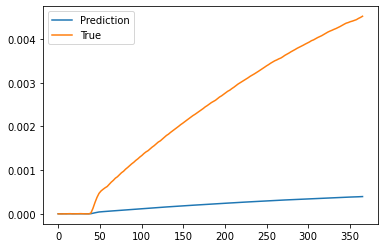

741 tensor(0.0649, grad_fn=<MseLossBackward>)
742 tensor(0.0567, grad_fn=<MseLossBackward>)
743 tensor(0.0606, grad_fn=<MseLossBackward>)
744 tensor(0.0518, grad_fn=<MseLossBackward>)
745 tensor(0.0637, grad_fn=<MseLossBackward>)
746 tensor(0.0611, grad_fn=<MseLossBackward>)
747 tensor(0.0497, grad_fn=<MseLossBackward>)
748 tensor(0.0537, grad_fn=<MseLossBackward>)
749 tensor(0.0567, grad_fn=<MseLossBackward>)
750 tensor(0.0603, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0938272e-01 6.5563506e-07 4.8596597e-01] [1.1952866e-01 5.9756899e-06 8.3461136e-01]


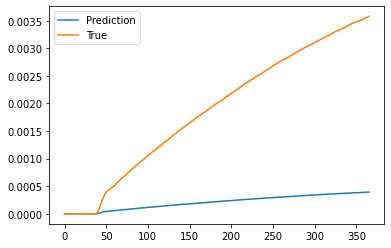

751 tensor(0.0617, grad_fn=<MseLossBackward>)
752 tensor(0.0571, grad_fn=<MseLossBackward>)
753 tensor(0.0512, grad_fn=<MseLossBackward>)
754 tensor(0.0497, grad_fn=<MseLossBackward>)
755 tensor(0.0596, grad_fn=<MseLossBackward>)
756 tensor(0.0608, grad_fn=<MseLossBackward>)
757 tensor(0.0533, grad_fn=<MseLossBackward>)
758 tensor(0.0528, grad_fn=<MseLossBackward>)
759 tensor(0.0543, grad_fn=<MseLossBackward>)
760 tensor(0.0497, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.092510e-01 6.562312e-07 4.859584e-01] [5.7679003e-01 1.7946394e-06 3.8292429e-01]


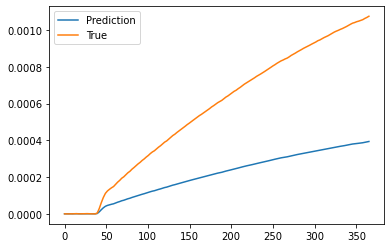

761 tensor(0.0594, grad_fn=<MseLossBackward>)
762 tensor(0.0637, grad_fn=<MseLossBackward>)
763 tensor(0.0458, grad_fn=<MseLossBackward>)
764 tensor(0.0549, grad_fn=<MseLossBackward>)
765 tensor(0.0646, grad_fn=<MseLossBackward>)
766 tensor(0.0585, grad_fn=<MseLossBackward>)
767 tensor(0.0594, grad_fn=<MseLossBackward>)
768 tensor(0.0618, grad_fn=<MseLossBackward>)
769 tensor(0.0586, grad_fn=<MseLossBackward>)
770 tensor(0.0524, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.091262e-01 6.557831e-07 4.859689e-01] [3.0607504e-01 4.6139717e-06 4.1212907e-01]


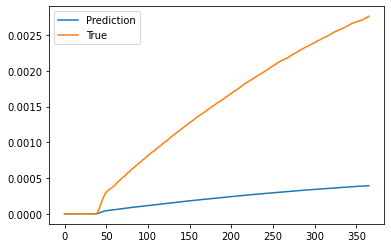

771 tensor(0.0625, grad_fn=<MseLossBackward>)
772 tensor(0.0580, grad_fn=<MseLossBackward>)
773 tensor(0.0636, grad_fn=<MseLossBackward>)
774 tensor(0.0616, grad_fn=<MseLossBackward>)
775 tensor(0.0598, grad_fn=<MseLossBackward>)
776 tensor(0.0593, grad_fn=<MseLossBackward>)
777 tensor(0.0709, grad_fn=<MseLossBackward>)
778 tensor(0.0639, grad_fn=<MseLossBackward>)
779 tensor(0.0637, grad_fn=<MseLossBackward>)
780 tensor(0.0585, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0917989e-01 6.5612272e-07 4.8605618e-01] [5.6709063e-01 2.5710060e-06 3.4389589e-02]


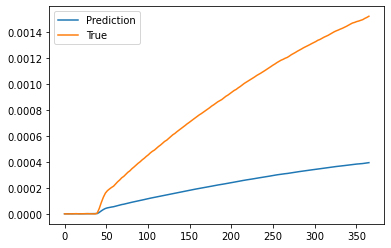

781 tensor(0.0671, grad_fn=<MseLossBackward>)
782 tensor(0.0622, grad_fn=<MseLossBackward>)
783 tensor(0.0630, grad_fn=<MseLossBackward>)
784 tensor(0.0542, grad_fn=<MseLossBackward>)
785 tensor(0.0543, grad_fn=<MseLossBackward>)
786 tensor(0.0572, grad_fn=<MseLossBackward>)
787 tensor(0.0545, grad_fn=<MseLossBackward>)
788 tensor(0.0553, grad_fn=<MseLossBackward>)
789 tensor(0.0583, grad_fn=<MseLossBackward>)
790 tensor(0.0735, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0912243e-01 6.5660726e-07 4.8594582e-01] [4.3571749e-01 6.7502100e-08 1.3252133e-01]


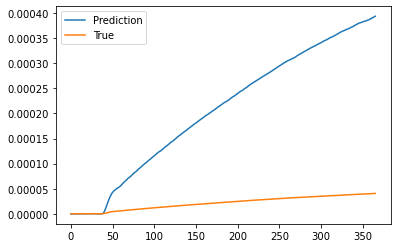

791 tensor(0.0535, grad_fn=<MseLossBackward>)
792 tensor(0.0505, grad_fn=<MseLossBackward>)
793 tensor(0.0643, grad_fn=<MseLossBackward>)
794 tensor(0.0529, grad_fn=<MseLossBackward>)
795 tensor(0.0543, grad_fn=<MseLossBackward>)
796 tensor(0.0589, grad_fn=<MseLossBackward>)
797 tensor(0.0610, grad_fn=<MseLossBackward>)
798 tensor(0.0562, grad_fn=<MseLossBackward>)
799 tensor(0.0543, grad_fn=<MseLossBackward>)
800 tensor(0.0622, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0930345e-01 6.5586988e-07 4.8600665e-01] [2.4216077e-01 4.3530163e-06 9.6496803e-01]


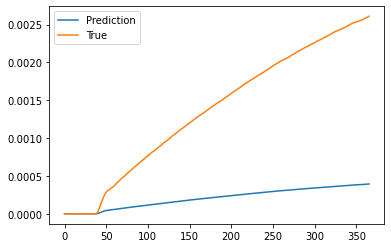

801 tensor(0.0713, grad_fn=<MseLossBackward>)
802 tensor(0.0563, grad_fn=<MseLossBackward>)
803 tensor(0.0531, grad_fn=<MseLossBackward>)
804 tensor(0.0594, grad_fn=<MseLossBackward>)
805 tensor(0.0572, grad_fn=<MseLossBackward>)
806 tensor(0.0563, grad_fn=<MseLossBackward>)
807 tensor(0.0618, grad_fn=<MseLossBackward>)
808 tensor(0.0640, grad_fn=<MseLossBackward>)
809 tensor(0.0571, grad_fn=<MseLossBackward>)
810 tensor(0.0503, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0925112e-01 6.5588307e-07 4.8597279e-01] [5.7413094e-02 4.1329508e-06 6.6904730e-01]


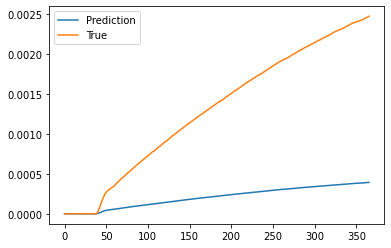

811 tensor(0.0643, grad_fn=<MseLossBackward>)
812 tensor(0.0607, grad_fn=<MseLossBackward>)
813 tensor(0.0567, grad_fn=<MseLossBackward>)
814 tensor(0.0525, grad_fn=<MseLossBackward>)
815 tensor(0.0504, grad_fn=<MseLossBackward>)
816 tensor(0.0647, grad_fn=<MseLossBackward>)
817 tensor(0.0611, grad_fn=<MseLossBackward>)
818 tensor(0.0509, grad_fn=<MseLossBackward>)
819 tensor(0.0660, grad_fn=<MseLossBackward>)
820 tensor(0.0576, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0931537e-01 6.5588426e-07 4.8598915e-01] [5.2873856e-01 4.2755673e-06 5.6431651e-02]


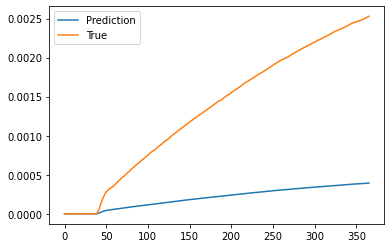

821 tensor(0.0611, grad_fn=<MseLossBackward>)
822 tensor(0.0516, grad_fn=<MseLossBackward>)
823 tensor(0.0516, grad_fn=<MseLossBackward>)
824 tensor(0.0674, grad_fn=<MseLossBackward>)
825 tensor(0.0568, grad_fn=<MseLossBackward>)
826 tensor(0.0584, grad_fn=<MseLossBackward>)
827 tensor(0.0610, grad_fn=<MseLossBackward>)
828 tensor(0.0605, grad_fn=<MseLossBackward>)
829 tensor(0.0563, grad_fn=<MseLossBackward>)
830 tensor(0.0557, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0909966e-01 6.5651801e-07 4.8597485e-01] [1.3029546e-01 3.7226354e-07 4.5457262e-01]


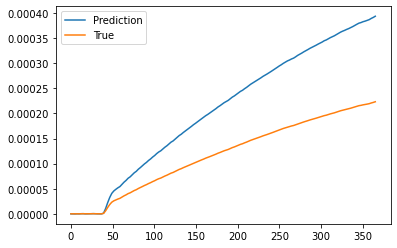

831 tensor(0.0487, grad_fn=<MseLossBackward>)
832 tensor(0.0490, grad_fn=<MseLossBackward>)
833 tensor(0.0532, grad_fn=<MseLossBackward>)
834 tensor(0.0543, grad_fn=<MseLossBackward>)
835 tensor(0.0640, grad_fn=<MseLossBackward>)
836 tensor(0.0643, grad_fn=<MseLossBackward>)
837 tensor(0.0621, grad_fn=<MseLossBackward>)
838 tensor(0.0609, grad_fn=<MseLossBackward>)
839 tensor(0.0629, grad_fn=<MseLossBackward>)
840 tensor(0.0560, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0926197e-01 6.5582003e-07 4.8610812e-01] [9.8333496e-01 4.7846984e-06 4.4178030e-01]


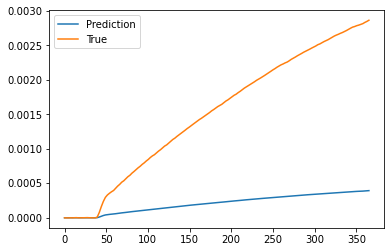

841 tensor(0.0657, grad_fn=<MseLossBackward>)
842 tensor(0.0562, grad_fn=<MseLossBackward>)
843 tensor(0.0596, grad_fn=<MseLossBackward>)
844 tensor(0.0588, grad_fn=<MseLossBackward>)
845 tensor(0.0546, grad_fn=<MseLossBackward>)
846 tensor(0.0615, grad_fn=<MseLossBackward>)
847 tensor(0.0708, grad_fn=<MseLossBackward>)
848 tensor(0.0641, grad_fn=<MseLossBackward>)
849 tensor(0.0576, grad_fn=<MseLossBackward>)
850 tensor(0.0542, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0925547e-01 6.5562904e-07 4.8597211e-01] [7.4771303e-01 5.8390533e-06 6.0444695e-01]


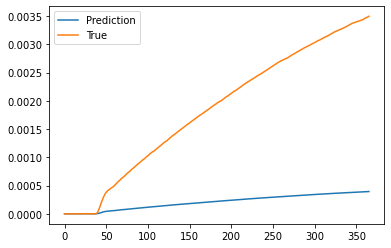

851 tensor(0.0585, grad_fn=<MseLossBackward>)
852 tensor(0.0640, grad_fn=<MseLossBackward>)
853 tensor(0.0503, grad_fn=<MseLossBackward>)
854 tensor(0.0653, grad_fn=<MseLossBackward>)
855 tensor(0.0548, grad_fn=<MseLossBackward>)
856 tensor(0.0655, grad_fn=<MseLossBackward>)
857 tensor(0.0534, grad_fn=<MseLossBackward>)
858 tensor(0.0549, grad_fn=<MseLossBackward>)
859 tensor(0.0652, grad_fn=<MseLossBackward>)
860 tensor(0.0578, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0923133e-01 6.5642490e-07 4.8598567e-01] [5.6874108e-01 7.9964525e-07 8.5682529e-01]


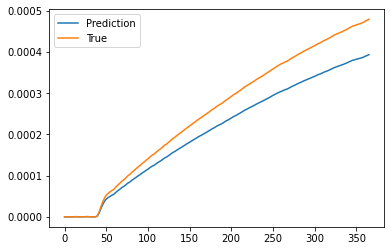

861 tensor(0.0630, grad_fn=<MseLossBackward>)
862 tensor(0.0577, grad_fn=<MseLossBackward>)
863 tensor(0.0559, grad_fn=<MseLossBackward>)
864 tensor(0.0539, grad_fn=<MseLossBackward>)
865 tensor(0.0637, grad_fn=<MseLossBackward>)
866 tensor(0.0621, grad_fn=<MseLossBackward>)
867 tensor(0.0542, grad_fn=<MseLossBackward>)
868 tensor(0.0599, grad_fn=<MseLossBackward>)
869 tensor(0.0623, grad_fn=<MseLossBackward>)
870 tensor(0.0547, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0923622e-01 6.5600528e-07 4.8601976e-01] [4.6943012e-01 3.3737408e-06 9.3937111e-01]


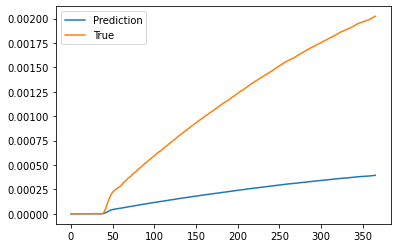

871 tensor(0.0549, grad_fn=<MseLossBackward>)
872 tensor(0.0548, grad_fn=<MseLossBackward>)
873 tensor(0.0573, grad_fn=<MseLossBackward>)
874 tensor(0.0496, grad_fn=<MseLossBackward>)
875 tensor(0.0605, grad_fn=<MseLossBackward>)
876 tensor(0.0574, grad_fn=<MseLossBackward>)
877 tensor(0.0560, grad_fn=<MseLossBackward>)
878 tensor(0.0609, grad_fn=<MseLossBackward>)
879 tensor(0.0561, grad_fn=<MseLossBackward>)
880 tensor(0.0531, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0925863e-01 6.5586607e-07 4.8599482e-01] [6.7533267e-01 4.2989700e-06 4.0884176e-01]


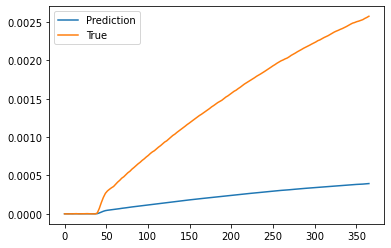

881 tensor(0.0546, grad_fn=<MseLossBackward>)
882 tensor(0.0591, grad_fn=<MseLossBackward>)
883 tensor(0.0593, grad_fn=<MseLossBackward>)
884 tensor(0.0569, grad_fn=<MseLossBackward>)
885 tensor(0.0553, grad_fn=<MseLossBackward>)
886 tensor(0.0586, grad_fn=<MseLossBackward>)
887 tensor(0.0577, grad_fn=<MseLossBackward>)
888 tensor(0.0601, grad_fn=<MseLossBackward>)
889 tensor(0.0542, grad_fn=<MseLossBackward>)
890 tensor(0.0642, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0926405e-01 6.5617968e-07 4.8608172e-01] [9.9804044e-01 2.3483810e-06 7.3560357e-02]


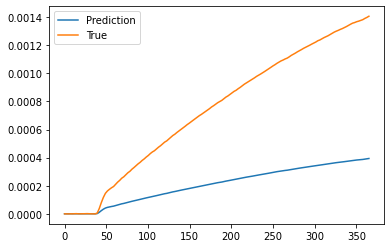

891 tensor(0.0588, grad_fn=<MseLossBackward>)
892 tensor(0.0636, grad_fn=<MseLossBackward>)
893 tensor(0.0525, grad_fn=<MseLossBackward>)
894 tensor(0.0531, grad_fn=<MseLossBackward>)
895 tensor(0.0604, grad_fn=<MseLossBackward>)
896 tensor(0.0645, grad_fn=<MseLossBackward>)
897 tensor(0.0554, grad_fn=<MseLossBackward>)
898 tensor(0.0507, grad_fn=<MseLossBackward>)
899 tensor(0.0627, grad_fn=<MseLossBackward>)
900 tensor(0.0547, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0950813e-01 6.5537643e-07 4.8604274e-01] [8.9337707e-01 7.8899848e-06 4.0676358e-01]


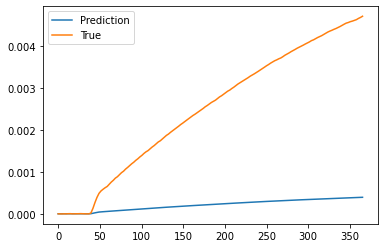

901 tensor(0.0624, grad_fn=<MseLossBackward>)
902 tensor(0.0537, grad_fn=<MseLossBackward>)
903 tensor(0.0545, grad_fn=<MseLossBackward>)
904 tensor(0.0521, grad_fn=<MseLossBackward>)
905 tensor(0.0608, grad_fn=<MseLossBackward>)
906 tensor(0.0606, grad_fn=<MseLossBackward>)
907 tensor(0.0541, grad_fn=<MseLossBackward>)
908 tensor(0.0625, grad_fn=<MseLossBackward>)
909 tensor(0.0493, grad_fn=<MseLossBackward>)
910 tensor(0.0570, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0933480e-01 6.5560056e-07 4.8600551e-01] [1.8415174e-01 6.2015743e-06 4.2079341e-01]


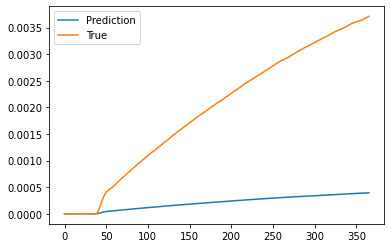

911 tensor(0.0529, grad_fn=<MseLossBackward>)
912 tensor(0.0513, grad_fn=<MseLossBackward>)
913 tensor(0.0540, grad_fn=<MseLossBackward>)
914 tensor(0.0595, grad_fn=<MseLossBackward>)
915 tensor(0.0505, grad_fn=<MseLossBackward>)
916 tensor(0.0631, grad_fn=<MseLossBackward>)
917 tensor(0.0553, grad_fn=<MseLossBackward>)
918 tensor(0.0556, grad_fn=<MseLossBackward>)
919 tensor(0.0581, grad_fn=<MseLossBackward>)
920 tensor(0.0560, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.092860e-01 6.559616e-07 4.860270e-01] [8.6121731e-02 3.7483862e-06 8.0961084e-01]


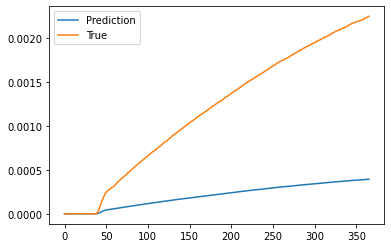

921 tensor(0.0571, grad_fn=<MseLossBackward>)
922 tensor(0.0627, grad_fn=<MseLossBackward>)
923 tensor(0.0550, grad_fn=<MseLossBackward>)
924 tensor(0.0536, grad_fn=<MseLossBackward>)
925 tensor(0.0617, grad_fn=<MseLossBackward>)
926 tensor(0.0556, grad_fn=<MseLossBackward>)
927 tensor(0.0575, grad_fn=<MseLossBackward>)
928 tensor(0.0503, grad_fn=<MseLossBackward>)
929 tensor(0.0661, grad_fn=<MseLossBackward>)
930 tensor(0.0663, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0924718e-01 6.5619167e-07 4.8596752e-01] [9.6496379e-01 2.0664888e-06 2.4400879e-01]


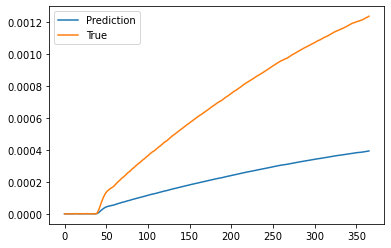

931 tensor(0.0606, grad_fn=<MseLossBackward>)
932 tensor(0.0663, grad_fn=<MseLossBackward>)
933 tensor(0.0619, grad_fn=<MseLossBackward>)
934 tensor(0.0656, grad_fn=<MseLossBackward>)
935 tensor(0.0544, grad_fn=<MseLossBackward>)
936 tensor(0.0562, grad_fn=<MseLossBackward>)
937 tensor(0.0563, grad_fn=<MseLossBackward>)
938 tensor(0.0687, grad_fn=<MseLossBackward>)
939 tensor(0.0679, grad_fn=<MseLossBackward>)
940 tensor(0.0572, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0936097e-01 6.5504145e-07 4.8595965e-01] [4.4895205e-01 9.4135685e-06 6.5424865e-01]


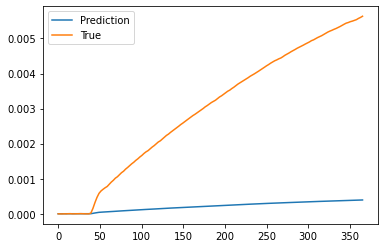

941 tensor(0.0496, grad_fn=<MseLossBackward>)
942 tensor(0.0655, grad_fn=<MseLossBackward>)
943 tensor(0.0555, grad_fn=<MseLossBackward>)
944 tensor(0.0645, grad_fn=<MseLossBackward>)
945 tensor(0.0651, grad_fn=<MseLossBackward>)
946 tensor(0.0547, grad_fn=<MseLossBackward>)
947 tensor(0.0577, grad_fn=<MseLossBackward>)
948 tensor(0.0585, grad_fn=<MseLossBackward>)
949 tensor(0.0579, grad_fn=<MseLossBackward>)
950 tensor(0.0514, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0925499e-01 6.5558982e-07 4.8594493e-01] [7.0700169e-01 6.0617435e-06 5.6385219e-01]


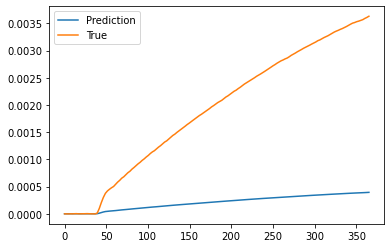

951 tensor(0.0477, grad_fn=<MseLossBackward>)
952 tensor(0.0601, grad_fn=<MseLossBackward>)
953 tensor(0.0584, grad_fn=<MseLossBackward>)
954 tensor(0.0560, grad_fn=<MseLossBackward>)
955 tensor(0.0567, grad_fn=<MseLossBackward>)
956 tensor(0.0651, grad_fn=<MseLossBackward>)
957 tensor(0.0577, grad_fn=<MseLossBackward>)
958 tensor(0.0577, grad_fn=<MseLossBackward>)
959 tensor(0.0628, grad_fn=<MseLossBackward>)
960 tensor(0.0631, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0926924e-01 6.5525307e-07 4.8596999e-01] [9.9359190e-01 8.1665221e-06 7.4398035e-01]


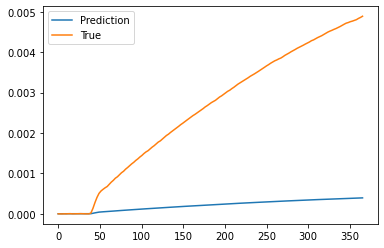

961 tensor(0.0529, grad_fn=<MseLossBackward>)
962 tensor(0.0575, grad_fn=<MseLossBackward>)
963 tensor(0.0567, grad_fn=<MseLossBackward>)
964 tensor(0.0635, grad_fn=<MseLossBackward>)
965 tensor(0.0516, grad_fn=<MseLossBackward>)
966 tensor(0.0571, grad_fn=<MseLossBackward>)
967 tensor(0.0596, grad_fn=<MseLossBackward>)
968 tensor(0.0557, grad_fn=<MseLossBackward>)
969 tensor(0.0537, grad_fn=<MseLossBackward>)
970 tensor(0.0694, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.093607e-01 6.551380e-07 4.859398e-01] [4.7422335e-03 8.9677442e-06 7.0817783e-02]


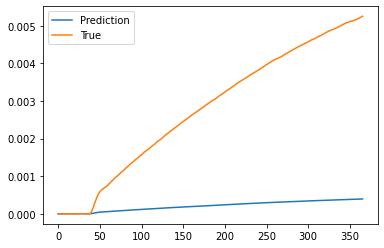

971 tensor(0.0496, grad_fn=<MseLossBackward>)
972 tensor(0.0598, grad_fn=<MseLossBackward>)
973 tensor(0.0522, grad_fn=<MseLossBackward>)
974 tensor(0.0632, grad_fn=<MseLossBackward>)
975 tensor(0.0579, grad_fn=<MseLossBackward>)
976 tensor(0.0538, grad_fn=<MseLossBackward>)
977 tensor(0.0566, grad_fn=<MseLossBackward>)
978 tensor(0.0570, grad_fn=<MseLossBackward>)
979 tensor(0.0591, grad_fn=<MseLossBackward>)
980 tensor(0.0603, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.0932443e-01 6.5522772e-07 4.8590302e-01] [3.7478387e-01 8.2923743e-06 4.1533560e-01]


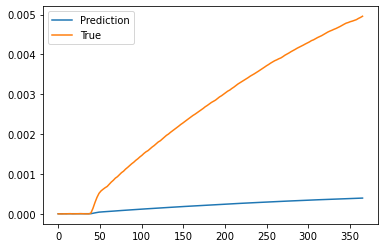

981 tensor(0.0511, grad_fn=<MseLossBackward>)
982 tensor(0.0564, grad_fn=<MseLossBackward>)
983 tensor(0.0562, grad_fn=<MseLossBackward>)
984 tensor(0.0480, grad_fn=<MseLossBackward>)
985 tensor(0.0565, grad_fn=<MseLossBackward>)
986 tensor(0.0578, grad_fn=<MseLossBackward>)
987 tensor(0.0687, grad_fn=<MseLossBackward>)
988 tensor(0.0617, grad_fn=<MseLossBackward>)
989 tensor(0.0587, grad_fn=<MseLossBackward>)
990 tensor(0.0558, grad_fn=<MseLossBackward>)
Prediction, True Values
[5.093188e-01 6.553426e-07 4.859963e-01] [9.7326893e-01 7.8994381e-06 1.6557546e-02]


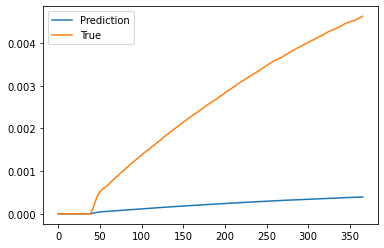

991 tensor(0.0622, grad_fn=<MseLossBackward>)
992 tensor(0.0482, grad_fn=<MseLossBackward>)
993 tensor(0.0498, grad_fn=<MseLossBackward>)
994 tensor(0.0521, grad_fn=<MseLossBackward>)
995 tensor(0.0503, grad_fn=<MseLossBackward>)
996 tensor(0.0631, grad_fn=<MseLossBackward>)
997 tensor(0.0577, grad_fn=<MseLossBackward>)
998 tensor(0.0544, grad_fn=<MseLossBackward>)
999 tensor(0.0652, grad_fn=<MseLossBackward>)


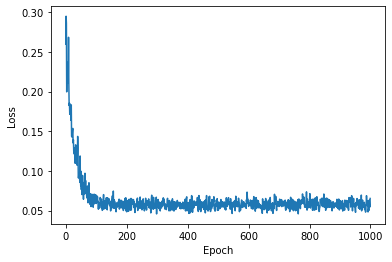

In [56]:
x, y = generate_xy(1000)
print(x[x<0].shape)
net = Net()

training_loop(x ,y ,epochs=1000)